In [1]:
# Codebase and experiments for the paper "Grokking as the transition from lazy to rich training dynamics"

In [1]:
# List of imports
from copy import deepcopy
from datetime import datetime
from functools import *
from itertools import product

import einops
import gc
import jax
import jax.numpy as jnp
import matplotlib
import neural_tangents as nt
import numpy as np
import optax
import os
import pandas as pd
import pickle
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import random as nrandom
import seaborn as sns
import shutil
import sys
import time
import torch
import torch.nn as nn
import torch.optim as optim
from jax import grad, jit, jacfwd, jacrev, lax, random, vmap
from jax.example_libraries import optimizers
from matplotlib import cm, pyplot as plt
from neural_tangents import stax
from pathlib import Path
from scipy.interpolate import BSpline, interp1d, make_interp_spline
from torch import matmul as mm
from torch._C import wait
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm

2025-05-10 21:31:35.154838: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746927095.166893   61614 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746927095.170462   61614 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746927095.179882   61614 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746927095.179893   61614 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746927095.179894   61614 computation_placer.cc:177] computation placer alr

In [2]:
cmap = matplotlib.colormaps.get_cmap('tab20')
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Grokking on Polynomial Regression Task (Section 5)

In [3]:
# Figure 1
D = 100
P = 550
N = 500

def target_fn(beta, X):
        return (X.T @ beta)**2/2.0

X = random.normal(random.PRNGKey(0), (D,P))/ jnp.sqrt(D)
Xt = random.normal(random.PRNGKey(1), (D,1000))/ jnp.sqrt(D)
beta = random.normal(random.PRNGKey(2), (D,))

y = target_fn(beta, X)
yt = target_fn(beta,Xt)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [4]:
W = random.normal(random.PRNGKey(0), (N, D))
a = random.normal(random.PRNGKey(0), (N, ))
params = [a, W]
alpha = 1 # scaling parameter, NOT weight norm scale
eps = 0.02

def NN_func2(params,X):
    global alpha
    global eps

    a, W = params
    D = W.shape[1]
    N = a.shape[0]
    h = W @ X.T

    f = alpha * np.mean(phi(h,eps),axis=0) # w/o readouts
    return f


def phi(z, eps = 0.25):
        return z + 0.5*eps*z**2

<Axes: >

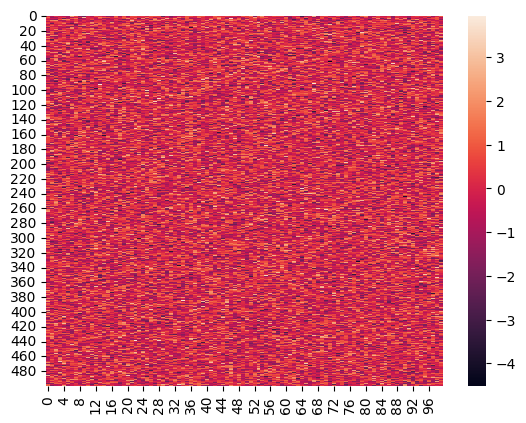

In [10]:
sns.heatmap(W)

In [12]:
ntk_fn = nt.empirical_ntk_fn(
    NN_func2, vmap_axes=0, trace_axes=())
#, implementation=nt.NtkImplementation.STRUCTURED_DERIVATIVES)

In [13]:
def kernel_regression(X, y, Xt, yt, params, which='test'):
      K_train = ntk_fn(X.T, None, params)

      a = jnp.linalg.solve(K_train, y)

      def estimate(xt):
        k_test_train = ntk_fn(Xt.T, X.T, params)
        k_test_train_squeezed = jnp.squeeze(k_test_train)
        return jnp.dot(k_test_train_squeezed, a)

      estimates = vmap(estimate)(Xt.T if which=='test' else X.T)
      labels = yt if which=='test' else y
      mse = jnp.mean((estimates - labels) ** 2)
      return mse


def kalignment(K, train_y):
    train_yc = train_y.reshape(-1, 1)
    train_yc = train_yc - train_yc.mean(axis=0)
    Kc = K - K.mean(axis=0)
    top = jnp.dot(jnp.dot(train_yc.T, Kc), train_yc)
    bottom = jnp.linalg.norm(Kc) * (jnp.linalg.norm(train_yc)**2)
    return jnp.trace(top)/bottom

In [14]:
W.shape

(500, 100)

  5%|███████▎                                                                                                                                          | 4998/100000 [01:54<18:10, 87.15it/s]

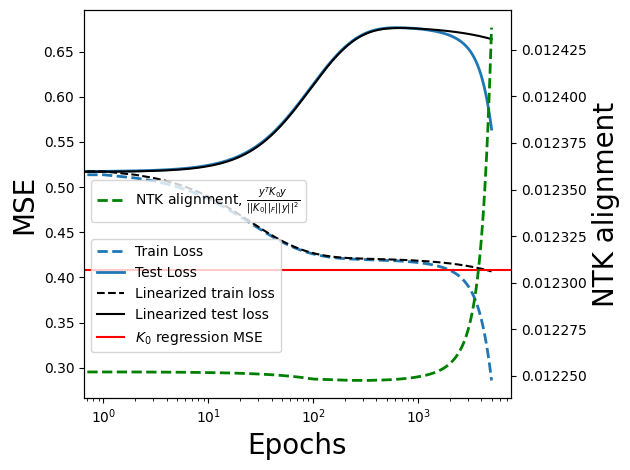

 10%|██████████████▌                                                                                                                                   | 9998/100000 [03:32<22:38, 66.25it/s]

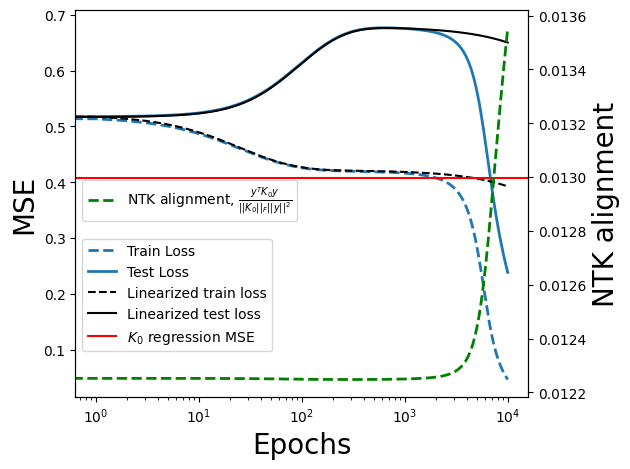

 15%|█████████████████████▋                                                                                                                           | 14993/100000 [05:09<14:38, 96.76it/s]

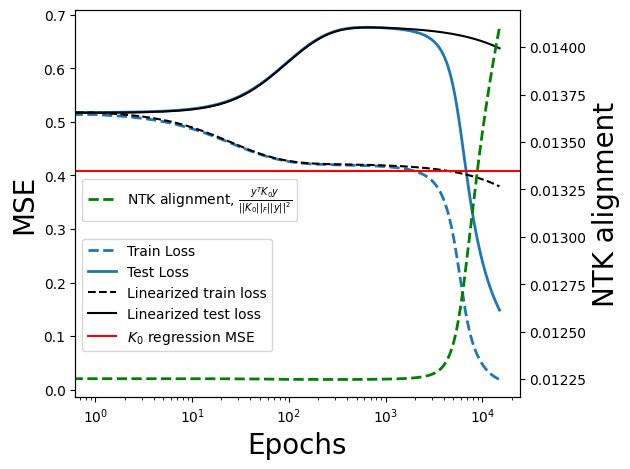

 16%|███████████████████████▋                                                                                                                         | 16349/100000 [05:33<20:57, 66.55it/s]

In [ ]:
kmse = kernel_regression(X, y, Xt, yt, params)

alphas = [1]
epsilons = [0.02]
epochs = 100000
CENTER_LOSS = True
TRAIN_READOUTS = False
ntk_interval = 100

for alpha in alphas:
  for eps in epsilons:
    kaligns_test = []
    epochs_to_plot = []
    dots = []

    Cs, As = [], []
    actual_w1aligns, actual_w2aligns = [], []
    w1_aligns, w2_aligns = [], []
    w1_vars, w2_vars, ws_covs = [], [], []
    vars_compute_interval = 50

    lamb = 0
    eta = N/alpha**2
    opt_init, opt_update, get_params = optimizers.sgd(eta)
    opt_init_lin, opt_update_lin, get_params_lin = optimizers.sgd(eta)

    opt_state = opt_init(params)
    opt_state_lin = opt_init_lin(params)

    f_lin = nt.linearize(NN_func2, params)
    lin_tr_losses = []
    lin_te_losses = []


    if CENTER_LOSS:
      loss_fn = jit(lambda p, X, y: jnp.mean( ( NN_func2(p, X.T)- NN_func2(params,X.T) - y )**2))
    else:
      loss_fn = jit(lambda p, X, y: jnp.mean( ( NN_func2(p, X) - y )**2 / alpha**2 ))

    f_lin0 = nt.linearize(NN_func2, params)
    lin_loss = jit(lambda p, X, y: jnp.mean((f_lin(p, X.T) - f_lin0(params, X.T) - y)**2)  )
    grad_loss_lin = jit(grad(lin_loss, 0))

    reg_loss = jit(lambda p, X, y: loss_fn(p,X,y) + lamb / alpha * optimizers.l2_norm(p)**2 )

    grad_loss = jit(grad(reg_loss,0))

    tr_losses = []
    te_losses = []

    alignments, alignmentst = [], []
    epochs_to_plot = []

    t1s, t2s, t3s, epochs_to_compute = [], [], [], []
    t1sm, t2sm, t3sm, ts_summ = [], [], [], []
    ts_sum = []
    alignments, alignmentst = [], []

    kmse = kernel_regression(X, y, Xt, yt, get_params(opt_state))

    for t in tqdm(range(epochs)):
      opt_state = opt_update(t, grad_loss(get_params(opt_state), X, y), opt_state)
      pars = get_params(opt_state)

      train_loss = loss_fn(pars, X, y)
      test_loss = loss_fn(pars, Xt, yt)
      tr_losses += [train_loss]
      te_losses += [test_loss]

      # new update rule for f_lin to compare learning curves
      lin_pars = get_params_lin(opt_state_lin)
      opt_state_lin = opt_update_lin(t, grad_loss_lin(lin_pars, X, y), opt_state_lin)

      lin_tr_losses += [ lin_loss(lin_pars, X, y) ]
      lin_te_losses += [ lin_loss(lin_pars, Xt, yt) ]

      if t % vars_compute_interval == 0:
          epochs_to_compute.append(t)
      if t % ntk_interval == 0 and t>0:
        K_test = ntk_fn(Xt.T, None, pars)
        cka_test = kalignment(K_test, yt)
        kaligns_test += [ cka_test ]

      if t % 5000 == 0 and t>0:
        from scipy.interpolate import interp1d
        max_t = t
        t_values = np.arange(0, max_t, ntk_interval)
        interpolator = interp1d(t_values, kaligns_test, kind='linear', fill_value='extrapolate')
        interpolated_kaligns = interpolator(np.arange(max_t))


        fig, ax1 = plt.subplots()

        col = cmap(0)
        ax1.plot(np.array(tr_losses), linestyle='--', label=rf'Train Loss', color=col, lw=2)
        ax1.plot(np.array(te_losses), label=rf'Test Loss', color=col, lw=2)
        ax1.plot(np.array(lin_tr_losses), color='black', linestyle='--', label=f'Linearized train loss')
        ax1.plot(np.array(lin_te_losses), color='black', label=f'Linearized test loss')
        ax1.axhline(kmse, color='r', label=rf'$K_0$ regression MSE')
        ax1.set_xlabel('Epochs', fontsize=20)
        ax1.set_xscale('log')
        ax1.set_ylabel('MSE', fontsize=20)
        ax1.legend(loc='lower left', bbox_to_anchor=(0, 0.1))

        ax2 = ax1.twinx()
        ax2.plot(interpolated_kaligns, linestyle='--', color='green', label=r'NTK alignment, $\frac{y^T K_0y}{||K_0||_F||y||^2}$', lw=2)
        ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.58))
        ax2.set_ylabel('NTK alignment', fontsize=20)
        plt.tight_layout()
        plt.show()

# Grokking on Modular Arithmetic Task

In [ ]:
# Figure 2. Modular arithmetic.

# p = 13
p = 23
D = 2*p  # Input units (each input is a pair of one-hot vectors)
alpha = 0.9  # Fraction of data used for training
scale = 1
lr = 1e2 / scale**2
seed= 1
N = 100
epochs = 50000
ntk_interval = int(epochs/10)

# scales = [0.1, 0.5, 1, 2, 5][::-1]
scales = [1]
trs, tls = [], []

class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, scale=1):
        super(SimpleMLP, self).__init__()
        self.D = input_dim
        self.N = hidden_dim
        self.scale = scale
        self.layer1 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.layer2 = nn.Linear(hidden_dim, output_dim, bias=False)

    def forward(self, x):
        # Split input into two parts (each representing one input integer)
        x = self.layer1(x)
        x = x**2  # Quadratic activation function
        x = self.layer2(x) * self.scale / (self.D * self.N)
        return x*scale


def modulo(x):
  a, b = torch.where(x == 1)[0]
  # grab the two numbers
  b -= p
  m = (a + b) % p
  return np.eye(p)[m].tolist()
    # Create dataset for modular arithmetic task

# Each input is a pair of one-hot vectors; each output is a one-hot vector
X = torch.tensor([np.eye(p)[i//p].tolist() + np.eye(p)[i%p].tolist() for i in range(p**2)])
y = torch.tensor([modulo(x) for x in X])
# Split dataset into train and test subsets
torch.manual_seed(seed)
indices = torch.randperm(p**2)
train_indices = indices[:int(alpha*(p**2))]
test_indices = indices[int(alpha*(p**2)):]
X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

tr_losses, te_losses = [], []
print(f"Grokking modular addition: p: {p}, D: {D}, train-set-frac: {alpha}, scale: {scale}, lr: {round(lr, 2)}, seed: {seed}, N: {N}, epochs: {epochs}")
model = SimpleMLP(D, N, p, scale)
for param in model.parameters():
    nn.init.normal_(param, mean=0, std=1)

loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

# Training
train_loss, test_loss = [], []
train_acc, test_acc = [], []
wnorms, kaligns, knorms, gnorms = [], [], [], [] # progress measures
train_kaligns = []
norms1, norms2, = [], []

for epoch in tqdm(range(epochs)):
    # Forward pass
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train) / float(scale**2)
    train_loss.append(loss.item())

    predicted = torch.argmax(y_pred, dim=1)
    correct = (predicted == torch.argmax(y_train, dim=1)).sum().item()
    train_acc.append(100 * correct / len(y_train))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()

    total_norm = 0.0
    total_grad_norm = 0.0 # gradient norm
    for par in model.parameters():
        param_norm = par.data.norm(2)
        total_norm += param_norm.item() ** 2

        if par.grad is not None:
            param_grad_norm = par.grad.data.norm(2)
            total_grad_norm += param_grad_norm.item() ** 2
    # wnorms.append(total_norm)

    t1 = list(model.parameters())[0]
    t2 = list(model.parameters())[1]
    norm1 = torch.norm(t1).item()
    norm2 = torch.norm(t2).item()

    norms1.append(norm1)
    norms2.append(norm2)
    wnorms.append(norm1 + norm2)
    gnorms.append(total_grad_norm)  # add this line

    optimizer.step()

    # Evaluate on test set
    with torch.no_grad():
        y_pred_test = model(X_test)
        test_loss.append(loss_fn(y_pred_test, y_test).item())

        predicted_test = torch.argmax(y_pred_test, dim=1)
        correct_test = (predicted_test == torch.argmax(y_test, dim=1)).sum().item()
        test_acc.append(100 * correct_test / len(y_test))

trs += [ train_acc ]
tls += [ test_acc ]

tr_losses += [ train_loss ]
te_losses += [ test_loss ]

cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in range(cmap.N)]
fig, ax1 = plt.subplots(figsize=(9, 6))
plt.rcParams.update({'font.size': 14})

ax1.set_xlabel('Epochs', fontsize=20)
ax1.set_ylabel('Accuracy', fontsize=20)
ax1.plot(range(epochs), train_acc, color=colors[0], label='Train accuracy', linestyle='--', dashes=(3, 4))
ax1.plot(range(epochs), test_acc, color=colors[0], label='Test accuracy')

ax2 = ax1.twinx()
ax2.plot(range(epochs), wnorms, color=colors[2], label='Weight Norm', linewidth=2, linestyle='--', dashes=(3, 4))
ax2.tick_params(axis='y')
ax2.set_ylabel('Weight Norm', fontsize=20)

# Get the legend details for ax1 and ax2
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# Combine the legend details
lines = lines1 + lines2
labels = labels1 + labels2

# Plot the combined legend
ax1.legend(lines, labels, loc='lower right', fontsize=20)  # you can adjust the location as needed

plt.tight_layout()
plt.savefig('2a')
plt.show()

plt.figure(figsize=(9, 6))
plt.plot(train_loss, label='Train loss', color=colors[0], linestyle='--', linewidth=2.0, dashes=(3, 4))
plt.plot(test_loss, label='Test loss', color=colors[0], linewidth=2.0)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig('2b')
plt.show()


In [ ]:
# 2(c). Sweep over laziness.
# Figure 2. Modular arithmetic.

# p = 13
p = 23
D = 2*p  # Input units (each input is a pair of one-hot vectors)
alpha = 0.9  # Fraction of data used for training
scale = 1
seed= 1
N = 100

ntk_interval = int(epochs/10)

# scales = [0.1, 0.5, 1, 2, 5][::-1]
scales = [1]
trs, tls = [], []

class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, scale=1):
        super(SimpleMLP, self).__init__()
        self.D = input_dim
        self.N = hidden_dim
        self.scale = scale
        self.layer1 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.layer2 = nn.Linear(hidden_dim, output_dim, bias=False)

    def forward(self, x):
        x = self.layer1(x)
        x = x**2  # Quadratic activation
        x = self.layer2(x) * self.scale / (self.D * self.N)
        return x*scale


def modulo(x):
  a, b = torch.where(x == 1)[0]
  # grab the two numbers
  b -= p
  m = (a + b) % p
  return np.eye(p)[m].tolist()
    # Create dataset for modular arithmetic task

# Each input is a pair of one-hot vectors; each output is a one-hot vector
X = torch.tensor([np.eye(p)[i//p].tolist() + np.eye(p)[i%p].tolist() for i in range(p**2)])
y = torch.tensor([modulo(x) for x in X])
torch.manual_seed(seed)
indices = torch.randperm(p**2)
train_indices = indices[:int(alpha*(p**2))]
test_indices = indices[int(alpha*(p**2)):]
X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

scales = [0.5, 1, 1.5, 2]
for scale in scales:
  lr = 1e2 / scale**2
  epochs = 100000
  tr_losses, te_losses = [], []
  # for wd in wds:
  print(f"Grokking modular addition: p: {p}, D: {D}, train-set-frac: {alpha}, scale: {scale}, lr: {round(lr, 2)}, seed: {seed}, N: {N}, epochs: {epochs}")
  model = SimpleMLP(D, N, p, scale)
  # winit_norm = 1
  for param in model.parameters(): # what if we change NTK0's spectral structure?
      nn.init.normal_(param, mean=0, std=1)

  loss_fn = nn.MSELoss()
  optimizer = optim.SGD(model.parameters(), lr=lr)
  # optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-6)

  # Training
  train_loss, test_loss = [], []
  train_acc, test_acc = [], []
  wnorms, kaligns, knorms, gnorms = [], [], [], [] # progress measures
  train_kaligns = []
  norms1, norms2, = [], []

  for epoch in tqdm(range(epochs)):
      # Forward pass
      y_pred = model(X_train)
      loss = loss_fn(y_pred, y_train) / float(scale**2)
      train_loss.append(loss.item())

      predicted = torch.argmax(y_pred, dim=1)
      correct = (predicted == torch.argmax(y_train, dim=1)).sum().item()
      train_acc.append(100 * correct / len(y_train))

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()

      total_norm = 0.0
      total_grad_norm = 0.0 # gradient norm
      for par in model.parameters():
          param_norm = par.data.norm(2)
          total_norm += param_norm.item() ** 2

          if par.grad is not None:
              param_grad_norm = par.grad.data.norm(2)
              total_grad_norm += param_grad_norm.item() ** 2

      t1 = list(model.parameters())[0]
      t2 = list(model.parameters())[1]
      norm1 = torch.norm(t1).item()
      norm2 = torch.norm(t2).item()

      norms1.append(norm1)
      norms2.append(norm2)
      wnorms.append(norm1 + norm2)
      gnorms.append(total_grad_norm)

      optimizer.step()

      with torch.no_grad():
          y_pred_test = model(X_test)
          test_loss.append(loss_fn(y_pred_test, y_test).item())

          predicted_test = torch.argmax(y_pred_test, dim=1)
          correct_test = (predicted_test == torch.argmax(y_test, dim=1)).sum().item()
          test_acc.append(100 * correct_test / len(y_test))

  trs += [ train_acc ]
  tls += [ test_acc ]

  tr_losses += [ train_loss ]
  te_losses += [ test_loss ]

import matplotlib.pyplot as plt

colors = ['g', 'b', 'r', 'black']
plt.figure(figsize=(9,6))
plt.rcParams.update({'font.size': 14})

plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)

for i in range(len(trs)):
  plt.plot(range(epochs), trs[i], color=colors[i], label=rf'Train, $\alpha={scales[i]}$', linestyle='--', linewidth=2.0, dashes=(3, 4))
  plt.plot(range(epochs), tls[i], color=colors[i], label=rf'Test, $\alpha={scales[i]}$', linewidth=2.0)

plt.legend(bbox_to_anchor=(0.67, 0.9), fontsize=16)
plt.tight_layout()
plt.show()




# Effect of Lazy Training and kernel misalignment on Grokking

In [ ]:
# Figure 3(a) and 3(b). Sweep over alpha and epsilon.

def phi(z, eps = 0.25):
    return z + 0.5*eps*z**2

def NN_func(params,X, alpha, eps=0.25):
    a, W = params

    D = W.shape[1]
    N = a.shape[0]

    h = W @ X / jnp.sqrt(D)
    f = alpha/N * phi(h, eps = eps).T @ a
    return f

def NN_func2(params,X, alpha, eps=0.25):
    a, W = params

    D = W.shape[1]
    N = a.shape[0]

    h = W @ X / jnp.sqrt(D)
    f = alpha * jnp.mean( phi(h, eps = eps), axis = 0)
    return f


def target_fn(beta, X):
    return (X.T @ beta / jnp.sqrt(D))**2

def phi(z, eps = 0.25):
    return z + 0.5*eps*z**2

def NN_func(params,X, alpha, eps=0.25):
    a, W = params

    D = W.shape[1]
    N = a.shape[0]

    h = W @ X / jnp.sqrt(D)
    f = alpha/N * phi(h, eps = eps).T @ a
    return f

def NN_func2(params,X, alpha, eps=0.25):
    a, W = params

    D = W.shape[1]
    N = a.shape[0]

    h = W @ X / jnp.sqrt(D)
    f = alpha * jnp.mean( phi(h, eps = eps), axis = 0)
    return f


def target_fn(beta, X):
    return (X.T @ beta / jnp.sqrt(D))**2


D = 100
P = 450
N = 500

X = random.normal(random.PRNGKey(0), (D,P))
Xt = random.normal(random.PRNGKey(1), (D,1000))
beta = random.normal(random.PRNGKey(2), (D,))

y = target_fn(beta, X)
yt = target_fn(beta,Xt)

a = random.normal(random.PRNGKey(0), (N, ))
W = random.normal(random.PRNGKey(0), (N, D))
params = [a, W]


eta = 0.5 * N
lamb = 0.0
opt_init, opt_update, get_params = optimizers.sgd(eta)

alphas = [2**(-5),0.25,0.5,1.0,2.0,4.0,8.0,16,32]

all_tr_losses = []
all_te_losses = []
all_acc_tr = []
all_acc_te = []

param_movement = []

for alpha in alphas:
    opt_state = opt_init(params)


    loss_fn = jit(lambda p, X, y: jnp.mean( ( NN_func2(p, X,alpha)- NN_func2(params,X,alpha) - y )**2 / alpha**2 ))
    acc_fn = jit(lambda p, X, y: jnp.mean( ( y * ( NN_func2(p, X,alpha)- NN_func2(params,X,alpha)) ) > 0.0 ))
    reg_loss = jit(lambda p, X, y: loss_fn(p,X,y) + lamb / alpha * optimizers.l2_norm(p)**2 )

    grad_loss = jit(grad(reg_loss,0))

    tr_losses = []
    te_losses = []
    tr_acc = []
    te_acc = []
    for t in range(60000):
        opt_state = opt_update(t, grad_loss(get_params(opt_state), X, y), opt_state)

        if t % 2 == 0:
            train_loss = alpha**2*loss_fn(get_params(opt_state), X, y)
            test_loss = alpha**2*loss_fn(get_params(opt_state), Xt, yt)
            tr_losses += [train_loss]
            te_losses += [test_loss]
            tr_acc += [ acc_fn(get_params(opt_state), X, y) ]
            te_acc += [ acc_fn(get_params(opt_state), Xt, yt) ]
            sys.stdout.write(f'\r t: {t} | train loss: {train_loss} | test loss: {test_loss}')
        if t % 10000 == 0:
            print(" ")

    all_tr_losses += [tr_losses]
    all_te_losses += [te_losses]
    all_acc_tr += [tr_acc]
    all_acc_te += [te_acc]

    paramsf = get_params(opt_state)
    dparam = (jnp.sum((paramsf[0]-params[0])**2) + jnp.sum((paramsf[1]-params[1])**2)) / ( jnp.sum( params[0]**2 ) + jnp.sum(params[1]**2) )
    param_movement += [  dparam ]

plt.rcParams.update({'font.size': 14})
plt.figure()
for i,alpha in enumerate(alphas[:-1]):
    print(alpha)
    plt.plot(jnp.linspace(1,len(all_tr_losses[i]),len(all_tr_losses[i])), jnp.array(all_tr_losses[i]) / all_tr_losses[i][0], '--',  color = f'C{i}')
    plt.plot(jnp.linspace(1,len(all_tr_losses[i]),len(all_tr_losses[i])), jnp.array(all_te_losses[i]) / all_te_losses[i][0],  color = f'C{i}', label = r'$\alpha = 2^{%0.0f}$' % jnp.log2(alpha))

plt.xscale('log')
plt.xlabel(r'$t$',fontsize = 20)
plt.ylabel('Loss',fontsize = 20)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


weight_norms = [0.125,0.25,0.5,1.0,2.0]
alpha = 1.0

eta = 0.5 * N
lamb = 0.0

all_tr_losses_w = []
all_te_losses_w = []
all_acc_tr_w = []
all_acc_te_w = []

param_movement_w = []

for i, wscale in enumerate(weight_norms):

    a = wscale * random.normal(random.PRNGKey(0), (N, ))
    W = wscale * random.normal(random.PRNGKey(0), (N, D))
    params = [a, W]

    opt_init, opt_update, get_params = optimizers.sgd( eta / wscale**2 )
    opt_state = opt_init(params)


    loss_fn = jit(lambda p, X, y: jnp.mean( ( NN_func2(p, X,alpha)- NN_func2(params,X,alpha) - y )**2 / alpha**2 ))
    acc_fn = jit(lambda p, X, y: jnp.mean( ( y * ( NN_func2(p, X,alpha)- NN_func2(params,X,alpha)) ) > 0.0 ))
    reg_loss = jit(lambda p, X, y: loss_fn(p,X,y) + lamb / alpha * optimizers.l2_norm(p)**2 )

    grad_loss = jit(grad(reg_loss,0))

    tr_losses = []
    te_losses = []
    tr_acc = []
    te_acc = []
    for t in range(50000):
        opt_state = opt_update(t, grad_loss(get_params(opt_state), X, y), opt_state)

        if t % 2 == 0:
            train_loss = alpha**2*loss_fn(get_params(opt_state), X, y)
            test_loss = alpha**2*loss_fn(get_params(opt_state), Xt, yt)
            tr_losses += [train_loss]
            te_losses += [test_loss]
            tr_acc += [ acc_fn(get_params(opt_state), X, y) ]
            te_acc += [ acc_fn(get_params(opt_state), Xt, yt) ]
            sys.stdout.write(f'\r t: {t} | train loss: {train_loss} | test loss: {test_loss}')
        if t % 10000 == 0:
            print(" ")

    all_tr_losses_w += [tr_losses]
    all_te_losses_w += [te_losses]
    all_acc_tr_w += [tr_acc]
    all_acc_te_w += [te_acc]

    paramsf = get_params(opt_state)
    dparam = (jnp.sum((paramsf[0]-params[0])**2) + jnp.sum((paramsf[1]-params[1])**2)) / ( jnp.sum( params[0]**2 ) + jnp.sum(params[1]**2) )
    param_movement_w += [  dparam ]

plt.rcParams.update({'font.size': 14})
plt.figure()
for i,wscale in enumerate(weight_norms):
    print(alpha)
    plt.plot(jnp.linspace(1,len(all_tr_losses_w[i]),len(all_tr_losses_w[i])), jnp.array(all_tr_losses_w[i]) / all_tr_losses_w[i][0], '--',  color = f'C{i}')
    plt.plot(jnp.linspace(1,len(all_tr_losses_w[i]),len(all_tr_losses_w[i])), jnp.array(all_te_losses_w[i]) / all_te_losses_w[i][0],  color = f'C{i}', label = r'$\sigma = 2^{%0.0f}$' % jnp.log2(wscale))
plt.xscale('log')
plt.xlabel('t',fontsize = 20)
plt.ylabel('Loss',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
# Figure 3(e). Empirical phase diagram sweep.
TRAIN_READOUTS = False
CENTER_LOSS = False

eps = 0.02
alpha = 1.0
D = 100
P = 550
N = 500

def target_fn(beta, X):
        return (X.T @ beta)**2/2.0

X = random.normal(random.PRNGKey(0), (D,P))/ jnp.sqrt(D)
Xt = random.normal(random.PRNGKey(1), (D,1000))/ jnp.sqrt(D)
beta = random.normal(random.PRNGKey(2), (D,))

y = target_fn(beta, X)
yt = target_fn(beta,Xt)

W = random.normal(random.PRNGKey(0), (N, D))

a = random.normal(random.PRNGKey(0), (N, ))
params = [a, W]

eta = 1 * N

alpha=1; eps = 0.02

def NN_func2(params,X):
    global alpha
    global eps

    a, W = params
    D = W.shape[1]
    N = a.shape[0]
    h = W @ X.T

    ap = a.reshape(-1, 1)
    if TRAIN_READOUTS: f = alpha * np.mean(ap * phi(h,eps),axis=0) # E^g decomp wrong for this
    else: f = alpha * np.mean(phi(h,eps),axis=0) # w/o readouts

    return f


def phi(z, eps = 0.25):
        return z + 0.5*eps*z**2 # can also try other functional forms for phi and for the target


ntk_fn = nt.empirical_ntk_fn(
    NN_func2, vmap_axes=0, trace_axes=(),
    implementation=nt.NtkImplementation.STRUCTURED_DERIVATIVES)

ntk = ntk_fn(X.T, None, params)

def kernel_regression(X, y, Xt, yt, params, which='test'):
      K_train = ntk_fn(X.T, None, params)

      a = jnp.linalg.solve(K_train, y)

      def estimate(xt):
        k_test_train = ntk_fn(Xt.T, X.T, params)
        k_test_train_squeezed = jnp.squeeze(k_test_train)
        return jnp.dot(k_test_train_squeezed, a)

      estimates = vmap(estimate)(Xt.T if which=='test' else X.T)
      labels = yt if which=='test' else y
      mse = jnp.mean((estimates - labels) ** 2)
      return mse


def kalignment(K, train_y):
    train_yc = train_y.reshape(-1, 1)
    train_yc = train_yc - train_yc.mean(axis=0)
    Kc = K - K.mean(axis=0)
    top = jnp.dot(jnp.dot(train_yc.T, Kc), train_yc)
    bottom = jnp.linalg.norm(Kc) * (jnp.linalg.norm(train_yc)**2)
    return jnp.trace(top)/bottom

kmse = kernel_regression(X, y, Xt, yt, params)

def find_first_index(tr_losses, x):
    indices = [idx for idx, value in enumerate(tr_losses) if value < x]
    return indices[0] if indices else -1

def fn(alpha, eps):
  W = random.normal(random.PRNGKey(0), (N, D))

  a = random.normal(random.PRNGKey(0), (N, ))
  pars = [a, W]

  lamb = 0
  eta = 20*N/alpha**2

  optimizer = optax.sgd(learning_rate=eta)
  opt_state = optimizer.init(pars)

  loss_fn = jit(lambda p, X, y: jnp.mean( ( NN_func2(p, X.T)- NN_func2(params,X.T) - y )**2))

  reg_loss = jit(lambda p, X, y: loss_fn(p,X,y) + lamb / alpha * optimizers.l2_norm(p)**2 )
  grad_loss = jit(grad(reg_loss,0))

  tr_losses = []
  te_losses = []

  # why is it stopping so early?

  # Convergence parameters
  delta_thresh = 1e-5  # Convergence threshold
  lookback = 5  # Number of previous steps to consider
  converged = False

  # Initial losses (epoch 0)
  init_train_loss = loss_fn(params, X, y)
  init_test_loss = loss_fn(params, Xt, yt)

  worst_test_loss = init_test_loss  # Initialize with epoch 0 value
  t = 0
  while not converged:
      grads = grad_loss(pars, X, y)
      updates, opt_state = optimizer.update(grads, opt_state, pars)
      pars = optax.apply_updates(pars, updates)

      train_loss = loss_fn(pars, X, y)
      test_loss = loss_fn(pars, Xt, yt)
      tr_losses += [train_loss]
      te_losses += [test_loss]

      # Update worst test loss
      worst_test_loss = max(worst_test_loss, test_loss)

      # Convergence condition
      if len(tr_losses) > lookback and len(te_losses) > lookback:
          tr_diff = jnp.abs(tr_losses[-1] - tr_losses[-lookback])
          te_diff = jnp.abs(te_losses[-1] - te_losses[-lookback])
          if tr_diff < delta_thresh and te_diff < delta_thresh and te_losses[-1] < init_test_loss or t>110000:
              converged = True
      t += 1

  final_train = tr_losses[-1]
  final_test = te_losses[-1]

  conv_tr, conv_te = {}, {}
  threshes = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
  for thresh in threshes:
    conv_tr[thresh] = find_first_index(tr_losses, thresh)
    conv_te[thresh] = find_first_index(te_losses, thresh)

  conv_tr['within_5%_final'] = find_first_index(tr_losses, (1.05 * final_train))
  conv_tr['within_10%_final'] = find_first_index(tr_losses, (1.1 * final_train))
  conv_tr['within_20%_final'] = find_first_index(tr_losses, (1.2 * final_train))

  conv_te['within_5%_final'] = find_first_index(tr_losses, (1.05 * final_test))
  conv_te['within_10%_final'] = find_first_index(tr_losses, (1.1 * final_test))
  conv_te['within_20%_final'] = find_first_index(tr_losses, (1.2 * final_test))

  plt.figure()
  plt.plot(tr_losses)
  plt.plot(te_losses)
  plt.xscale('log')
  plt.show()

  print(f'final_train={final_train}, final_test={final_test}, tr_conv_when={conv_tr[0.05]}, te_conv_when={conv_te[0.05]}, init_train_loss={init_train_loss}, init_test_loss={init_test_loss}, worst_test_loss={worst_test_loss}')
  return final_train, final_test, conv_tr, conv_te, init_train_loss, init_test_loss, worst_test_loss

alphas = [0.4 * i for i in range(1, 15)]
epsilons = [0.02 * i for i in range(1, 15)]

results = {}

for alpha in tqdm(alphas):
  print(f'Beginning alpha={alpha}')
  for eps in tqdm(epsilons):
    # should serialize these somewhere as this sweep can take 10+ hours
    results[(alpha, eps)] = fn(alpha, eps)

matrix = np.zeros((len(alphas), len(epsilons)))

# Populate the matrix using the 'results' dictionary
for i, alpha in enumerate(alphas):
    for j, eps in enumerate(epsilons):
        conv_tr, conv_te = results[(alpha, eps)][2], results[(alpha, eps)][3]
        matrix[i, j] = max(0, conv_te[0.1] - conv_tr[0.1])

# Interpolate to get a higher resolution matrix for smooth visualization
interp_factor = 2  # The factor by which we increase the resolution
matrix_high_res = np.kron(matrix, np.ones((interp_factor, interp_factor)))  # Kronecker product does the trick

# Plot the heatmap
plt.figure()
plt.imshow(matrix_high_res, interpolation='bilinear', origin='lower', extent=[min(epsilons), max(epsilons), min(alphas), max(alphas)], aspect='auto', cmap='OrRd')
plt.colorbar(label='Amount of Grokking')
plt.xlabel(r'Kernel Alignment', fontsize=20)
plt.ylabel(r'Laziness', fontsize=20)
plt.tight_layout()
plt.show()


# Loss curves for Polynomial Regression Task 

In [ ]:
# Figure 4. Loss Decomposition.
D = 40
N = 2
alpha = 1
eps = 0.25
P = 120
alphas = [1]

epochs = 50000

ntk_interval = 200
vars_compute_interval = 10

all_tr_losses_eps = []
all_te_losses_eps = []
all_alignments, all_alignmentst = [], []

for alpha in alphas:
  def phi(z, eps = 0.25):
      return z + 0.5*eps*z**2

  def NN_func2(params,X, alpha, eps = 0.25):
      a, W = params
      D = W.shape[1]
      N = a.shape[0]
      h = W @ X

      f = alpha * np.mean(phi(h,eps),axis=0) # w/o readouts

      return f

  def target_fn(beta, X):
      return (X.T @ beta)**2/2.0

  X = random.normal(random.PRNGKey(0), (D,P))/ jnp.sqrt(D)
  Xt = random.normal(random.PRNGKey(1), (D,1000))/ jnp.sqrt(D)
  beta = random.normal(random.PRNGKey(2), (D,))

  y = target_fn(beta, X)
  yt = target_fn(beta,Xt)

  W = random.normal(random.PRNGKey(0), (N, D))

  a = random.normal(random.PRNGKey(0), (N, ))
  params = [a, W]

  eta = 0.5 * N / alpha**2
  lamb = 0
  opt_init, opt_update, get_params = optimizers.sgd(eta)

  opt_state = opt_init(params)
  loss_fn = jit(lambda p, X, y: jnp.mean( ( NN_func2(p, X,alpha, eps) - y )**2 ))
  reg_loss = jit(lambda p, X, y: loss_fn(p,X,y) + lamb / alpha * optimizers.l2_norm(p)**2 )

  grad_loss = jit(grad(reg_loss,0))

  tr_losses = []
  te_losses = []

  epochs_to_plot = []

  t1s, t2s, t3s, epochs_to_compute = [], [], [], []
  t1sm, t2sm, t3sm, ts_summ = [], [], [], []
  ts_sum = []


  for t in tqdm(range(epochs)):
    opt_state = opt_update(t, grad_loss(get_params(opt_state), X, y), opt_state)
    pars = get_params(opt_state)

    train_loss = loss_fn(pars, X, y)
    test_loss = loss_fn(pars, Xt, yt)
    tr_losses += [train_loss]
    te_losses += [test_loss]

    if t % vars_compute_interval == 0:
        W = pars[1]
        A = W @ beta / D
        M = W.T @ W / N

        t1m = (alpha * eps/2.0 * 1.0/D * np.trace(M) - np.mean(beta**2)/2)**2
        t2m = (1/2) * np.mean( ( alpha*eps* M - np.outer(beta, beta) )**2 )
        t3m = alpha**2 * (1/D) * np.linalg.norm(np.mean(W, axis=0))**2

        t1sm.append(t1m)
        t2sm.append(t2m)
        t3sm.append(t3m)
        ts_summ.append(t1m + t2m + t3m)

        epochs_to_compute.append(t)

  all_tr_losses_eps += [tr_losses]
  all_te_losses_eps += [te_losses]

  T_compute = np.array(epochs_to_compute)

  t1sm_spline = make_interp_spline(T_compute, np.array(t1sm), k=3)
  t2sm_spline = make_interp_spline(T_compute, np.array(t2sm), k=3)
  t3sm_spline = make_interp_spline(T_compute, np.array(t3sm), k=3)

  t1sm_smooth = t1sm_spline(np.arange(epochs))
  t2sm_smooth = t2sm_spline(np.arange(epochs))
  t3sm_smooth = t3sm_spline(np.arange(epochs))
  ts_summ_smooth = make_interp_spline(T_compute, np.array(ts_summ), k=3)(np.arange(epochs))

  tit = f'N={N}, P={P}, D={D}, eps={eps}, lr={round(eta, 2)}, alpha={round(alpha, 2)}, lamb={lamb}'
  # let's check if our decomp here with A,M is equiv to what BB wrote in current manuscript, bc i suspect that (rather than wbar' or M') is the prob

  def get_random_color():
      return np.random.rand(3,)

  plt.figure(figsize=(9, 6))
  plt.plot(tr_losses, label='Train Loss')
  plt.plot(te_losses, label='Test Loss')
  plt.xscale('log')
  plt.xlabel('Epochs', fontsize=20)
  plt.ylabel('MSE', fontsize=20)
  plt.legend(fontsize=14)
  plt.tight_layout()
  plt.show()

  plt.figure(figsize=(9, 6))
  plt.plot(ts_summ_smooth, label='Full Test Loss', color='darkorange')
  plt.plot(t1sm_smooth, label='Variance error component', color='red', linestyle='--')
  plt.plot(t2sm_smooth, label='Alignment error component', color='green', linestyle='--')
  plt.plot(t3sm_smooth, label='Linear term error component', color='black', linestyle='--')
  plt.xscale('log')
  plt.ylabel('MSE', fontsize=20)
  plt.xlabel('Epochs', fontsize=20)
  plt.legend(fontsize=14)
  plt.tight_layout()
  plt.show()


In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(tr_losses, label='Train Loss')
plt.plot(te_losses, label='Test Loss')
plt.xscale('log')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig('readouts_lcs.pdf')
plt.show()

plt.figure(figsize=(9, 6))
plt.plot(ts_summ_smooth, label='Full Test Loss', color='darkorange')
plt.plot(t1sm_smooth, label='Variance error component', color='red', linestyle='--')
plt.plot(t2sm_smooth, label='Alignment error component', color='green', linestyle='--')
plt.plot(t3sm_smooth, label='Linear term error component', color='black', linestyle='--')
plt.xscale('log')
plt.ylabel('MSE', fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig('readouts_decomp.pdf')
plt.show()


# Grokking on Gaussian Data

In [ ]:
# Figure 5. Grokking on arbitrary datasets but setting labels to goldilocks eigenvectors of kernel matrix K(X, X).
all_tr_losses_eps = []
all_te_losses_eps = []

def phi(z, eps = 0.25):
    return z + 0.5*eps*z**2
def phi2(z, eps = 0.25):
    return 0.5*eps*z**2

def phi3(z, eps = 0.25):
    return 0.5*eps*z**3

def phi4(z, eps = 0.25):
  def relu(z):
    return jax.numpy.maximum(0, z)
  return relu(z) + 0.5*eps*z**4

def phi5(z, eps = 0.25):
    return 0.5*eps*z**4

def plot(P=100, N=2, D=100, k=75, alpha=1, phi=phi, eps=0.25, epochs=25000, path='test'):
  def get_K(params, X):
    def ntk(X, params, NN_func2, alpha, eps):
      f = NN_func2(params, X, alpha, eps)
      grad_f = jacrev(lambda W, X: NN_func2([params[0], W], X, alpha, eps))(params[1], X)
      return jnp.tensordot(grad_f, grad_f, axes=((1, 2), (1, 2)))

    return ntk(X, params, NN_func2, alpha, eps)

  def NN_func2(params,X, alpha, eps = eps):
      a, W = params

      D = W.shape[1]
      N = a.shape[0]

      h = W @ X / jnp.sqrt(D)
      f = alpha * jnp.mean( phi(h, eps), axis = 0)
      return f

  def target_fn(beta, X):
      return (X.T @ beta / jnp.sqrt(D))**2

  def generate_label_vector(X, k, params):
      K = get_K(params, X)
      K -= np.mean(K)

      eigenvalues, eigenvectors = jnp.linalg.eigh(K)
      eigenvalues = eigenvalues[::-1]
      eigenvectors = eigenvectors[:, ::-1]
      y = eigenvectors[:, k - 1]

      return y

  X_total = random.normal(random.PRNGKey(0), (D, 2 * P))
  params_total = [random.normal(random.PRNGKey(0), (N, )), random.normal(random.PRNGKey(0), (N, D))]
  y_total = generate_label_vector(X_total, k, params_total)

  X = X_total[:, :P]
  Xt = X_total[:, P:]
  y = y_total[:P]
  yt = y_total[P:]

  a = random.normal(random.PRNGKey(0), (N, ))
  W = random.normal(random.PRNGKey(0), (N, D))
  params = [a, W]

  eta = 0.5 * N / alpha**2
  lamb = 0
  opt_init, opt_update, get_params = optimizers.sgd(eta)

  tit = f'Eigvec grokking: p={P}, D={D}, N={N}, scale={alpha}, lr={eta}, eps={eps}, eigk={k}, phi={phi}, lamb={lamb}'
  print(tit)
  opt_state = opt_init(params)


  loss_fn = jit(lambda p, X, y: jnp.mean( ( NN_func2(p, X,alpha, eps)- NN_func2(params,X,alpha, eps) - y )**2 / alpha**2 ))
  acc_fn = jit(lambda p, X, y: jnp.mean( ( y * ( NN_func2(p, X,alpha,eps)- NN_func2(params,X,alpha,eps)) ) > 0.0 ))
  reg_loss = jit(lambda p, X, y: loss_fn(p,X,y) + lamb / alpha * optimizers.l2_norm(p)**2 )
  grad_loss = jit(grad(reg_loss,0))

  tr_losses = []
  te_losses = []

  epochs_to_plot = []
  dots = []

  for t in tqdm(range(epochs)):
    params_current = get_params(opt_state)
    opt_state = opt_update(t, grad_loss(params_current, X, y), opt_state)
    train_loss = alpha**2*loss_fn(params_current, X, y)
    test_loss = alpha**2*loss_fn(params_current, Xt, yt)
    tr_losses += [train_loss]
    te_losses += [test_loss]

  plt.figure()
  plt.plot(np.array(tr_losses), label='Train Loss', linestyle='--')
  plt.plot(np.array(te_losses), label='Test Loss')
  plt.xscale('log')
  plt.xlabel('Epochs', fontsize=20)
  plt.ylabel('MSE', fontsize=20)
  plt.tight_layout()
  plt.legend()

  plt.show()

alpha = 1
scale = 1
P = 100
D = 100
N = 2
ks = [1, 5, 70, 75, 100, 150]
for k in ks:
  plot(P=P, D=D, k=k, path='k', alpha=scale, N=N)



# Grokking on One-Layer Transfomer (Modular Arithmetic Task)

In [ ]:
# Grokking in a One-Layer Transformer on a modular arithmetic task
# Replicated then modified to induce lazy dynamics from Neel Nanda's MI paper: 
# https://arxiv.org/pdf/2301.05217.pdf 
# and code at https://colab.research.google.com/drive/1F6_1_cWXE5M7WocUcpQWp3v8z4b1jL20
import random
import torch.nn.functional as F

!git clone https://github.com/neelnanda-io/Grokking.git
root = Path('/content/Grokking/saved_runs')
large_root = Path('/content/Grokking/large_files')
try:
    os.mkdir(large_root)
except:
    pass
!pip install gdown
!gdown 12pmgxpTHLDzSNMbMCuAMXP1lE_XiCQRy -O /content/Grokking/large_files/full_run_data.pth

class HookPoint(nn.Module):
    def __init__(self):
        super().__init__()
        self.fwd_hooks = []
        self.bwd_hooks = []

    def give_name(self, name):
        # Called by the model at initialisation
        self.name = name

    def add_hook(self, hook, dir='fwd'):
        # Hook format is fn(activation, hook_name)
        # Change it into PyTorch hook format (this includes input and output,
        # which are the same for a HookPoint)
        def full_hook(module, module_input, module_output):
            return hook(module_output, name=self.name)
        if dir=='fwd':
            handle = self.register_forward_hook(full_hook)
            self.fwd_hooks.append(handle)
        elif dir=='bwd':
            handle = self.register_backward_hook(full_hook)
            self.bwd_hooks.append(handle)
        else:
            raise ValueError(f"Invalid direction {dir}")

    def remove_hooks(self, dir='fwd'):
        if (dir=='fwd') or (dir=='both'):
            for hook in self.fwd_hooks:
                hook.remove()
            self.fwd_hooks = []
        if (dir=='bwd') or (dir=='both'):
            for hook in self.bwd_hooks:
                hook.remove()
            self.bwd_hooks = []
        if dir not in ['fwd', 'bwd', 'both']:
            raise ValueError(f"Invalid direction {dir}")

    def forward(self, x):
        return x


# Embed & Unembed
class Embed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_E = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_model))

    def forward(self, x):
        return torch.einsum('dbp -> bpd', self.W_E[:, x])

class Unembed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_U = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_vocab))

    def forward(self, x):
        return (x @ self.W_U)

# Positional Embeddings
class PosEmbed(nn.Module):
    def __init__(self, max_ctx, d_model):
        super().__init__()
        self.W_pos = nn.Parameter(torch.randn(max_ctx, d_model)/np.sqrt(d_model))

    def forward(self, x):
        return x+self.W_pos[:x.shape[-2]]

# LayerNorm
class LayerNorm(nn.Module):
    def __init__(self, d_model, epsilon = 1e-4, model=[None]):
        super().__init__()
        self.model = model
        self.w_ln = nn.Parameter(torch.ones(d_model))
        self.b_ln = nn.Parameter(torch.zeros(d_model))
        self.epsilon = epsilon

    def forward(self, x):
        if self.model[0].use_ln:
            x = x - x.mean(axis=-1)[..., None]
            x = x / (x.std(axis=-1)[..., None] + self.epsilon)
            x = x * self.w_ln
            x = x + self.b_ln
            return x
        else:
            return x

# Attention
class Attention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, n_ctx, model):
        super().__init__()
        self.model = model
        self.scale = scale
        self.W_K = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_Q = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_V = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_O = nn.Parameter(torch.randn(d_model, d_head * num_heads)/np.sqrt(d_model))
        self.register_buffer('mask', torch.tril(torch.ones((n_ctx, n_ctx))))
        self.d_head = d_head
        self.hook_k = HookPoint()
        self.hook_q = HookPoint()
        self.hook_v = HookPoint()
        self.hook_z = HookPoint()
        self.hook_attn = HookPoint()
        self.hook_attn_pre = HookPoint()

    def forward(self, x):
        k = self.hook_k(torch.einsum('ihd,bpd->biph', self.W_K, x))
        q = self.hook_q(torch.einsum('ihd,bpd->biph', self.W_Q, x))
        v = self.hook_v(torch.einsum('ihd,bpd->biph', self.W_V, x))
        attn_scores_pre = torch.einsum('biph,biqh->biqp', k, q)
        attn_scores_masked = torch.tril(attn_scores_pre) - 1e10 * (1 - self.mask[:x.shape[-2], :x.shape[-2]])
        attn_matrix = self.hook_attn(F.softmax(self.hook_attn_pre(attn_scores_masked/np.sqrt(self.d_head)), dim=-1))
        z = self.hook_z(torch.einsum('biph,biqp->biqh', v, attn_matrix))
        z_flat = einops.rearrange(z, 'b i q h -> b q (i h)')
        out = torch.einsum('df,bqf->bqd', self.W_O, z_flat)
        return out

# MLP Layers
class MLP(nn.Module):
    def __init__(self, d_model, d_mlp, act_type, model):
        super().__init__()
        self.model = model
        self.W_in = nn.Parameter(torch.randn(d_mlp, d_model)/np.sqrt(d_model))
        self.b_in = nn.Parameter(torch.zeros(d_mlp))
        self.W_out = nn.Parameter(torch.randn(d_model, d_mlp)/np.sqrt(d_model))
        self.b_out = nn.Parameter(torch.zeros(d_model))
        self.act_type = act_type
        # self.ln = LayerNorm(d_mlp, model=self.model)
        self.hook_pre = HookPoint()
        self.hook_post = HookPoint()
        assert act_type in ['ReLU', 'GeLU']

    def forward(self, x):
        x = self.hook_pre(torch.einsum('md,bpd->bpm', self.W_in, x) + self.b_in)
        if self.act_type=='ReLU':
            x = F.relu(x)
        elif self.act_type=='GeLU':
            x = F.gelu(x)
        x = self.hook_post(x)
        x = torch.einsum('dm,bpm->bpd', self.W_out, x) + self.b_out
        return x

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model):
        super().__init__()
        torch.manual_seed(1)
        torch.cuda.manual_seed(1)
        self.model = model
        # self.ln1 = LayerNorm(d_model, model=self.model)
        self.attn = Attention(d_model, num_heads, d_head, n_ctx, model=self.model)
        # self.ln2 = LayerNorm(d_model, model=self.model)
        self.mlp = MLP(d_model, d_mlp, act_type, model=self.model)
        self.hook_attn_out = HookPoint()
        self.hook_mlp_out = HookPoint()
        self.hook_resid_pre = HookPoint()
        self.hook_resid_mid = HookPoint()
        self.hook_resid_post = HookPoint()

    def forward(self, x):
        x = self.hook_resid_mid(x + self.hook_attn_out(self.attn((self.hook_resid_pre(x)))))
        x = self.hook_resid_post(x + self.hook_mlp_out(self.mlp((x))))
        return x

# Full transformer
class Transformer(nn.Module):
    def __init__(self, num_layers, d_vocab, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, use_cache=False, use_ln=True, scale=1.0):
        super().__init__()
        self.cache = {}
        self.scale = scale
        self.use_cache = use_cache

        self.embed = Embed(d_vocab, d_model)
        self.pos_embed = PosEmbed(n_ctx, d_model)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model=[self]) for i in range(num_layers)])
        # self.ln = LayerNorm(d_model, model=[self])
        self.unembed = Unembed(d_vocab, d_model)
        self.use_ln = use_ln

        for name, module in self.named_modules():
            if type(module)==HookPoint:
                module.give_name(name)

    def forward(self, x):
        x = self.embed(x)
        x = self.pos_embed(x)
        for block in self.blocks:
            x = block(x)
        # x = self.ln(x)
        x = self.unembed(x)
        return x*self.scale

    def set_use_cache(self, use_cache):
        self.use_cache = use_cache

    def hook_points(self):
        return [module for name, module in self.named_modules() if 'hook' in name]

    def remove_all_hooks(self):
        for hp in self.hook_points():
            hp.remove_hooks('fwd')
            hp.remove_hooks('bwd')

    def cache_all(self, cache, incl_bwd=False):
        # Caches all activations wrapped in a HookPoint
        def save_hook(tensor, name):
            cache[name] = tensor.detach()
        def save_hook_back(tensor, name):
            cache[name+'_grad'] = tensor[0].detach()
        for hp in self.hook_points():
            hp.add_hook(save_hook, 'fwd')
            if incl_bwd:
                hp.add_hook(save_hook_back, 'bwd')

# Helper functions
def cuda_memory():
    print(torch.cuda.memory_allocated()/1e9)

def cross_entropy_high_precision(logits, labels):
    logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
    prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
    loss = -torch.mean(prediction_logprobs)
    return loss

def full_loss(model, data):
    logits = model(data)[:, -1]
    labels = torch.tensor([fn(i, j) for i, j, _ in data]).to('cuda')
    return cross_entropy_high_precision(logits, labels)

def test_logits(logits, bias_correction=False, original_logits=None, mode='all'):
    if logits.shape[1]==p*p:
        logits = logits.T
    if logits.shape==torch.Size([p*p, p+1]):
        logits = logits[:, :-1]
    logits = logits.reshape(p*p, p)
    if bias_correction:
        # Applies bias correction - we correct for any missing bias terms,
        # independent of the input, by centering the new logits along the batch
        # dimension, and then adding the average original logits across all inputs
        logits = einops.reduce(original_logits - logits, 'batch ... -> ...', 'mean') + logits
    if mode=='train':
        return cross_entropy_high_precision(logits[is_train], labels[is_train])
    elif mode=='test':
        return cross_entropy_high_precision(logits[is_test], labels[is_test])
    elif mode=='all':
        return cross_entropy_high_precision(logits, labels)


# Helper functions
def cuda_memory():
    print(torch.cuda.memory_allocated()/1e9)

def cross_entropy_high_precision(logits, labels):
    # Shapes: batch x vocab, batch
    # Cast logits to float64 because log_softmax has a float32 underflow on overly
    # confident data and can only return multiples of 1.2e-7 (the smallest float x
    # such that 1+x is different from 1 in float32). This leads to loss spikes
    # and dodgy gradients
    logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
    prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
    loss = -torch.mean(prediction_logprobs)
    return loss

def full_loss(model, data):
    # Take the final position only
    logits = model(data)[:, -1]
    labels = torch.tensor([fn(i, j) for i, j, _ in data]).to('cuda')
    return cross_entropy_high_precision(logits, labels)

def test_logits(logits, bias_correction=False, original_logits=None, mode='all'):
    # Calculates cross entropy loss of logits representing a batch of all p^2
    # possible inputs
    # Batch dimension is assumed to be first
    if logits.shape[1]==p*p:
        logits = logits.T
    if logits.shape==torch.Size([p*p, p+1]):
        logits = logits[:, :-1]
    logits = logits.reshape(p*p, p)
    if bias_correction:
        # Applies bias correction - we correct for any missing bias terms,
        # independent of the input, by centering the new logits along the batch
        # dimension, and then adding the average original logits across all inputs
        logits = einops.reduce(original_logits - logits, 'batch ... -> ...', 'mean') + logits
    if mode=='train':
        return cross_entropy_high_precision(logits[is_train], labels[is_train])
    elif mode=='test':
        return cross_entropy_high_precision(logits[is_test], labels[is_test])
    elif mode=='all':
        return cross_entropy_high_precision(logits, labels)

# want Plotly hacking practice
def to_numpy(tensor, flat=False):
    if type(tensor)!=torch.Tensor:
        return tensor
    if flat:
        return tensor.flatten().detach().cpu().numpy()
    else:
        return tensor.detach().cpu().numpy()
def imshow(tensor, xaxis=None, yaxis=None, animation_name='Snapshot', **kwargs):
    if tensor.shape[0]==p*p:
        tensor = unflatten_first(tensor)
    tensor = torch.squeeze(tensor)
    px.imshow(to_numpy(tensor, flat=False),
              labels={'x':xaxis, 'y':yaxis, 'animation_name':animation_name},
              **kwargs).show()
# Set default colour scheme
imshow = partial(imshow, color_continuous_scale='Blues')
# Creates good defaults for showing divergent colour scales (ie with both
# positive and negative values, where 0 is white)
imshow_div = partial(imshow, color_continuous_scale='RdBu', color_continuous_midpoint=0.0)
# Presets a bunch of defaults to imshow to make it suitable for showing heatmaps
# of activations with x axis being input 1 and y axis being input 2.
inputs_heatmap = partial(imshow, xaxis='Input 1', yaxis='Input 2', color_continuous_scale='RdBu', color_continuous_midpoint=0.0)
def line(x, y=None, hover=None, xaxis='', yaxis='', **kwargs):
    if type(y)==torch.Tensor:
        y = to_numpy(y, flat=True)
    if type(x)==torch.Tensor:
        x=to_numpy(x, flat=True)
    fig = px.line(x, y=y, hover_name=hover, **kwargs)
    fig.update_layout(xaxis_title=xaxis, yaxis_title=yaxis)
    fig.show()
def scatter(x, y, **kwargs):
    px.scatter(x=to_numpy(x, flat=True), y=to_numpy(y, flat=True), **kwargs).show()
def lines(lines_list, x=None, mode='lines', labels=None, xaxis='', yaxis='', title = '', log_y=False, hover=None, **kwargs):
    # Helper function to plot multiple lines
    if type(lines_list)==torch.Tensor:
        lines_list = [lines_list[i] for i in range(lines_list.shape[0])]
    if x is None:
        x=np.arange(len(lines_list[0]))
    fig = go.Figure(layout={'title':title})
    fig.update_xaxes(title=xaxis)
    fig.update_yaxes(title=yaxis)
    for c, line in enumerate(lines_list):
        if type(line)==torch.Tensor:
            line = to_numpy(line)
        if labels is not None:
            label = labels[c]
        else:
            label = c
        fig.add_trace(go.Scatter(x=x, y=line, mode=mode, name=label, hovertext=hover, **kwargs))
    if log_y:
        fig.update_layout(yaxis_type="log")
    fig.show()
def line_marker(x, **kwargs):
    lines([x], mode='lines+markers', **kwargs)
def animate_lines(lines_list, snapshot_index = None, snapshot='snapshot', hover=None, xaxis='x', yaxis='y', **kwargs):
    if type(lines_list)==list:
        lines_list = torch.stack(lines_list, axis=0)
    lines_list = to_numpy(lines_list, flat=False)
    if snapshot_index is None:
        snapshot_index = np.arange(lines_list.shape[0])
    if hover is not None:
        hover = [i for j in range(len(snapshot_index)) for i in hover]
    print(lines_list.shape)
    rows=[]
    for i in range(lines_list.shape[0]):
        for j in range(lines_list.shape[1]):
            rows.append([lines_list[i][j], snapshot_index[i], j])
    df = pd.DataFrame(rows, columns=[yaxis, snapshot, xaxis])
    px.line(df, x=xaxis, y=yaxis, animation_frame=snapshot, range_y=[lines_list.min(), lines_list.max()], hover_name=hover,**kwargs).show()

def imshow_fourier(tensor, title='', animation_name='snapshot', facet_labels=[], **kwargs):
    # Set nice defaults for plotting functions in the 2D fourier basis
    # tensor is assumed to already be in the Fourier Basis
    if tensor.shape[0]==p*p:
        tensor = unflatten_first(tensor)
    tensor = torch.squeeze(tensor)
    fig=px.imshow(to_numpy(tensor),
            x=fourier_basis_names,
            y=fourier_basis_names,
            labels={'x':'x Component',
                    'y':'y Component',
                    'animation_frame':animation_name},
            title=title,
            color_continuous_midpoint=0.,
            color_continuous_scale='RdBu',
            **kwargs)
    fig.update(data=[{'hovertemplate':"%{x}x * %{y}y<br>Value:%{z:.4f}"}])
    if facet_labels:
        for i, label in enumerate(facet_labels):
            fig.layout.annotations[i]['text'] = label
    fig.show()

def animate_multi_lines(lines_list, y_index=None, snapshot_index = None, snapshot='snapshot', hover=None, swap_y_animate=False, **kwargs):
    # Can plot an animation of lines with multiple lines on the plot.
    if type(lines_list)==list:
        lines_list = torch.stack(lines_list, axis=0)
    lines_list = to_numpy(lines_list, flat=False)
    if swap_y_animate:
        lines_list = lines_list.transpose(1, 0, 2)
    if snapshot_index is None:
        snapshot_index = np.arange(lines_list.shape[0])
    if y_index is None:
        y_index = [str(i) for i in range(lines_list.shape[1])]
    if hover is not None:
        hover = [i for j in range(len(snapshot_index)) for i in hover]
    print(lines_list.shape)
    rows=[]
    for i in range(lines_list.shape[0]):
        for j in range(lines_list.shape[2]):
            rows.append(list(lines_list[i, :, j])+[snapshot_index[i], j])
    df = pd.DataFrame(rows, columns=y_index+[snapshot, 'x'])
    px.line(df, x='x', y=y_index, animation_frame=snapshot, range_y=[lines_list.min(), lines_list.max()], hover_name=hover, **kwargs).show()

def animate_scatter(lines_list, snapshot_index = None, snapshot='snapshot', hover=None, yaxis='y', xaxis='x', color=None, color_name = 'color', **kwargs):
    # Can plot an animated scatter plot
    # lines_list has shape snapshot x 2 x line
    if type(lines_list)==list:
        lines_list = torch.stack(lines_list, axis=0)
    lines_list = to_numpy(lines_list, flat=False)
    if snapshot_index is None:
        snapshot_index = np.arange(lines_list.shape[0])
    if hover is not None:
        hover = [i for j in range(len(snapshot_index)) for i in hover]
    if color is None:
        color = np.ones(lines_list.shape[-1])
    if type(color)==torch.Tensor:
        color = to_numpy(color)
    if len(color.shape)==1:
        color = einops.repeat(color, 'x -> snapshot x', snapshot=lines_list.shape[0])
    print(lines_list.shape)
    rows=[]
    for i in range(lines_list.shape[0]):
        for j in range(lines_list.shape[2]):
            rows.append([lines_list[i, 0, j].item(), lines_list[i, 1, j].item(), snapshot_index[i], color[i, j]])
    print([lines_list[:, 0].min(), lines_list[:, 0].max()])
    print([lines_list[:, 1].min(), lines_list[:, 1].max()])
    df = pd.DataFrame(rows, columns=[xaxis, yaxis, snapshot, color_name])
    px.scatter(df, x=xaxis, y=yaxis, animation_frame=snapshot, range_x=[lines_list[:, 0].min(), lines_list[:, 0].max()], range_y=[lines_list[:, 1].min(), lines_list[:, 1].max()], hover_name=hover, color=color_name, **kwargs).show()

def unflatten_first(tensor):
    if tensor.shape[0]==p*p:
        return einops.rearrange(tensor, '(x y) ... -> x y ...', x=p, y=p)
    else:
        return tensor
def cos(x, y):
    return (x.dot(y))/x.norm()/y.norm()
def mod_div(a, b):
    return (a*pow(b, p-2, p))%p
def normalize(tensor, axis=0):
    return tensor/(tensor).pow(2).sum(keepdim=True, axis=axis).sqrt()
def extract_freq_2d(tensor, freq):
    # Takes in a pxpx... or batch x ... tensor, returns a 3x3x... tensor of the
    # Linear and quadratic terms of frequency freq
    tensor = unflatten_first(tensor)
    # Extracts the linear and quadratic terms corresponding to frequency freq
    index_1d = [0, 2*freq-1, 2*freq]
    # Some dumb manipulation to use fancy array indexing rules
    # Gets the rows and columns in index_1d
    return tensor[[[i]*3 for i in index_1d], [index_1d]*3]
def get_cov(tensor, norm=True):
    # Calculate covariance matrix
    if norm:
        tensor = normalize(tensor, axis=1)
    return tensor @ tensor.T
def is_close(a, b):
    return ((a-b).pow(2).sum()/(a.pow(2).sum().sqrt())/(b.pow(2).sum().sqrt())).item()

def unflatten_first(tensor):
    if tensor.shape[0]==p*p:
        return einops.rearrange(tensor, '(x y) ... -> x y ...', x=p, y=p)
    else:
        return tensor
def cos(x, y):
    return (x.dot(y))/x.norm()/y.norm()
def mod_div(a, b):
    return (a*pow(b, p-2, p))%p
def normalize(tensor, axis=0):
    return tensor/(tensor).pow(2).sum(keepdim=True, axis=axis).sqrt()
def extract_freq_2d(tensor, freq):
    # Takes in a pxpx... or batch x ... tensor, returns a 3x3x... tensor of the
    # Linear and quadratic terms of frequency freq
    tensor = unflatten_first(tensor)
    # Extracts the linear and quadratic terms corresponding to frequency freq
    index_1d = [0, 2*freq-1, 2*freq]
    # Some dumb manipulation to use fancy array indexing rules
    # Gets the rows and columns in index_1d
    return tensor[[[i]*3 for i in index_1d], [index_1d]*3]
def get_cov(tensor, norm=True):
    # Calculate covariance matrix
    if norm:
        tensor = normalize(tensor, axis=1)
    return tensor @ tensor.T
def is_close(a, b):
    return ((a-b).pow(2).sum()/(a.pow(2).sum().sqrt())/(b.pow(2).sum().sqrt())).item()


lr=1e-3 #@param
weight_decay = 1.0 #@param
p=113 #@param
d_model = 128 #@param
fn_name = 'add' #@param ['add', 'subtract', 'x2xyy2','rand']
frac_train = 0.4 #@param
num_epochs = 50000 #@param
save_models = True #@param
save_every = 100 #@param
# Stop training when test loss is <stopping_thresh
stopping_thresh = -1 #@param
seed = 0 #@param

num_layers = 1
batch_style = 'full'
d_vocab = p+1
n_ctx = 3
d_mlp = 4*d_model
num_heads = 4
assert d_model % num_heads == 0
d_head = d_model//num_heads
act_type = 'ReLU' #@param ['ReLU', 'GeLU']
# batch_size = 512
use_ln = False
random_answers = np.random.randint(low=0, high=p, size=(p, p))
fns_dict = {'add': lambda x,y:(x+y)%p, 'subtract': lambda x,y:(x-y)%p, 'x2xyy2':lambda x,y:(x**2+x*y+y**2)%p, 'rand':lambda x,y:random_answers[x][y]}
fn = fns_dict[fn_name]

train_model = True #@param

def gen_train_test(frac_train, num, seed=0):
    # Generate train and test split
    pairs = [(i, j, num) for i in range(num) for j in range(num)]
    random.seed(seed)
    random.shuffle(pairs)
    div = int(frac_train*len(pairs))
    return pairs[:div], pairs[div:]

train, test = gen_train_test(frac_train, p, seed)

# Creates an array of Boolean indices according to whether each data point is in
# train or test
# Used to index into the big batch of all possible data
is_train = []
is_test = []
for x in range(p):
    for y in range(p):
        if (x, y, 113) in train:
            is_train.append(True)
            is_test.append(False)
        else:
            is_train.append(False)
            is_test.append(True)
is_train = np.array(is_train)
is_test = np.array(is_test)


def centered_loss(model, model_init, data): # modified
    # Take the final position only
    logits = model(data)[:, -1]
    with torch.no_grad():
      logits_init = model_init(data)[:, -1]
    labels = torch.tensor([fn(i, j) for i, j, _ in data]).to('cuda')
    return cross_entropy_high_precision(logits-logits_init, labels) # train the model to produce logits relative to init

from tqdm import tqdm
from copy import deepcopy

num_epochs = 200000

scales = [0.05 * i for i in range(1, 11)]
tls = []
trs = []
save_models = True

if train_model:
  for scale in scales:
      model = Transformer(num_layers=num_layers, d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp, d_head=d_head, num_heads=num_heads, n_ctx=n_ctx, act_type=act_type, use_cache=False, use_ln=use_ln, scale=scale)
      # transformer has same random seed upon init
      model_init = deepcopy(model) # we'll use this to center loss

      model_init.to('cuda')
      model.to('cuda')

      lr=6e-6 #@param
      optimizer = optim.AdamW(model.parameters(), lr=lr/scale**2, weight_decay=weight_decay, betas=(0.9, 0.98))
      scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(step/10, 1))
      run_name = f"grok_{int(time.time())}"
      print(f'Run name {run_name}')
      if save_models:
          os.mkdir(root/run_name)
          save_dict = {'model':model.state_dict(), 'train_data':train, 'test_data':test}
          torch.save(save_dict, root/run_name/'init.pth')
      train_losses = []
      test_losses = []
      for epoch in tqdm(range(num_epochs)):
          train_loss = centered_loss(model, model_init, train)
          test_loss = centered_loss(model, model_init, test)
          train_losses.append(train_loss.item())
          test_losses.append(test_loss.item())
          train_loss.backward()
          optimizer.step()
          scheduler.step()
          optimizer.zero_grad()
          if test_loss.item() < stopping_thresh:
              break

      trs += [train_losses]
      tls += [test_losses]

In [ ]:
plt.figure()
for i in range(len(trs)):
    plt.plot(trs[i], linestyle='--', color=colors[i], label=rf'$Train, \alpha$={scale}')
    plt.plot(tls[i], color=colors[i], label=rf'$Test, \alpha$={scale}')

plt.tight_layout()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Cross Entropy Loss', fontsize=20)

# Appendix Plots

# Weight norm and laziness have the same effect.

In [ ]:
# Weight norm and laziness have the same effect.
from jax import random # sometimes we use jax.random and sometimes python.random

def phi(z, eps = 0.25):
    return z + 0.5*eps*z**2

def NN_func(params,X, alpha, eps=0.25):
    a, W = params

    D = W.shape[1]
    N = a.shape[0]

    h = W @ X / jnp.sqrt(D)
    f = alpha/N * phi(h, eps = eps).T @ a
    return f

def NN_func2(params,X, alpha, eps=0.25):
    a, W = params

    D = W.shape[1]
    N = a.shape[0]

    h = W @ X / jnp.sqrt(D)
    f = alpha * jnp.mean( phi(h, eps = eps), axis = 0)
    return f


def target_fn(beta, X):
    return (X.T @ beta / jnp.sqrt(D))**2


D = 100
P = 450
N = 500

X = random.normal(random.PRNGKey(0), (D,P))
Xt = random.normal(random.PRNGKey(1), (D,1000))
beta = random.normal(random.PRNGKey(2), (D,))

y = target_fn(beta, X)
yt = target_fn(beta,Xt)

a = random.normal(random.PRNGKey(0), (N, ))
W = random.normal(random.PRNGKey(0), (N, D))
params = [a, W]


eta = 0.5 * N
lamb = 0.0
opt_init, opt_update, get_params = optimizers.sgd(eta)

alphas = [2**(-5),0.25,0.5,1.0,2.0,4.0,8.0,16,32]

all_tr_losses = []
all_te_losses = []
all_acc_tr = []
all_acc_te = []

param_movement = []

weight_norms = [0.125,0.25,0.5,1.0,2.0]
alpha = 1.0

eta = 0.5 * N
lamb = 0.0

all_tr_losses_w = []
all_te_losses_w = []
all_acc_tr_w = []
all_acc_te_w = []

param_movement_w = []

for i, wscale in enumerate(weight_norms):

    a = wscale * random.normal(random.PRNGKey(0), (N, ))
    W = wscale * random.normal(random.PRNGKey(0), (N, D))
    params = [a, W]

    opt_init, opt_update, get_params = optimizers.sgd( eta / wscale**2 )
    opt_state = opt_init(params)


    loss_fn = jit(lambda p, X, y: jnp.mean( ( NN_func2(p, X,alpha)- NN_func2(params,X,alpha) - y )**2 / alpha**2 ))
    acc_fn = jit(lambda p, X, y: jnp.mean( ( y * ( NN_func2(p, X,alpha)- NN_func2(params,X,alpha)) ) > 0.0 ))
    reg_loss = jit(lambda p, X, y: loss_fn(p,X,y) + lamb / alpha * optimizers.l2_norm(p)**2 )

    grad_loss = jit(grad(reg_loss,0))

    tr_losses = []
    te_losses = []
    tr_acc = []
    te_acc = []
    for t in range(50000):
        opt_state = opt_update(t, grad_loss(get_params(opt_state), X, y), opt_state)

        if t % 2 == 0:
            train_loss = alpha**2*loss_fn(get_params(opt_state), X, y)
            test_loss = alpha**2*loss_fn(get_params(opt_state), Xt, yt)
            tr_losses += [train_loss]
            te_losses += [test_loss]
            tr_acc += [ acc_fn(get_params(opt_state), X, y) ]
            te_acc += [ acc_fn(get_params(opt_state), Xt, yt) ]
            sys.stdout.write(f'\r t: {t} | train loss: {train_loss} | test loss: {test_loss}')
        if t % 10000 == 0:
            print(" ")

    all_tr_losses_w += [tr_losses]
    all_te_losses_w += [te_losses]
    all_acc_tr_w += [tr_acc]
    all_acc_te_w += [te_acc]

    paramsf = get_params(opt_state)
    dparam = (jnp.sum((paramsf[0]-params[0])**2) + jnp.sum((paramsf[1]-params[1])**2)) / ( jnp.sum( params[0]**2 ) + jnp.sum(params[1]**2) )
    param_movement_w += [  dparam ]


plt.rcParams.update({'font.size': 14})
plt.figure()
for i,wscale in enumerate(weight_norms):
    print(alpha)
    plt.plot(jnp.linspace(1,len(all_tr_losses_w[i]),len(all_tr_losses_w[i])), jnp.array(all_tr_losses_w[i]) / all_tr_losses_w[i][0], '--',  color = f'C{i}')
    plt.plot(jnp.linspace(1,len(all_tr_losses_w[i]),len(all_tr_losses_w[i])), jnp.array(all_te_losses_w[i]) / all_te_losses_w[i][0],  color = f'C{i}', label = r'$\sigma = 2^{%0.0f}$' % jnp.log2(wscale))
plt.xscale('log')
plt.xlabel('t',fontsize = 20)
plt.ylabel('Loss',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.show()

plt.loglog(alphas, jnp.sqrt(jnp.array(param_movement)),'-o', label = r'vary $\alpha$, $\sigma=1$')
plt.loglog(jnp.array(weight_norms)**2, jnp.array(param_movement_w)**(0.5) ,'--o', label =r'vary $\sigma$, $\alpha=1$')
plt.xlabel(r'$\sigma^2 \alpha$', fontsize = 20)
plt.ylabel(r'$|\theta-\theta_0|/|\theta_0|$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.show()

final_losses_w =  [ te_loss[-1]  for te_loss in all_te_losses_w ]
final_losses = [ te_loss[-1] for te_loss in all_te_losses ]

plt.loglog(alphas, final_losses, '-o', label = r'vary $\alpha$, $\sigma=1$')
plt.loglog(jnp.array(weight_norms)**2, final_losses_w, '--o', label =r'vary $\sigma$, $\alpha=1$')
plt.xlabel(r'$\sigma^2 \alpha$', fontsize = 20)
plt.ylabel(r'Final Test Loss',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.show()


plt.loglog(jnp.sqrt(jnp.array(param_movement)) , final_losses, '-o', label = r'vary $\alpha$, $\sigma=1$')
plt.loglog(jnp.array(param_movement_w)**(0.5), final_losses_w, '--o', label =r'vary $\sigma$, $\alpha=1$')
plt.xlabel(r'$|\theta-\theta_0|/|\theta_0|$', fontsize = 20)
plt.ylabel(r'Final Test Loss',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.show()


weight_norms = [0.25,0.5,1.0,2.0]
alpha_base = 1.0

eta = 0.5 * N
lamb = 0.0

all_tr_losses_walpha = []
all_te_losses_walpha = []
all_acc_tr_walpha = []
all_acc_te_walpha = []

param_movement_walpha = []

for i, wscale in enumerate(weight_norms):

    a = wscale * random.normal(random.PRNGKey(0), (N, ))
    W = wscale * random.normal(random.PRNGKey(0), (N, D))
    params = [a, W]

    alpha = alpha_base / wscale**2
    opt_init, opt_update, get_params = optimizers.sgd( eta / wscale**2 )
    opt_state = opt_init(params)


    loss_fn = jit(lambda p, X, y: jnp.mean( ( NN_func2(p, X,alpha)- NN_func2(params,X,alpha) - y )**2 / alpha**2 ))
    acc_fn = jit(lambda p, X, y: jnp.mean( ( y * ( NN_func2(p, X,alpha)- NN_func2(params,X,alpha)) ) > 0.0 ))
    reg_loss = jit(lambda p, X, y: loss_fn(p,X,y) + lamb / alpha * optimizers.l2_norm(p)**2 )

    grad_loss = jit(grad(reg_loss,0))

    tr_losses = []
    te_losses = []
    tr_acc = []
    te_acc = []
    for t in range(50000):
        opt_state = opt_update(t, grad_loss(get_params(opt_state), X, y), opt_state)

        if t % 2 == 0:
            train_loss = alpha**2*loss_fn(get_params(opt_state), X, y)
            test_loss = alpha**2*loss_fn(get_params(opt_state), Xt, yt)
            tr_losses += [train_loss]
            te_losses += [test_loss]
            tr_acc += [ acc_fn(get_params(opt_state), X, y) ]
            te_acc += [ acc_fn(get_params(opt_state), Xt, yt) ]
            sys.stdout.write(f'\r t: {t} | train loss: {train_loss} | test loss: {test_loss}')
        if t % 10000 == 0:
            print(" ")

    all_tr_losses_walpha += [tr_losses]
    all_te_losses_walpha += [te_losses]
    all_acc_tr_walpha += [tr_acc]
    all_acc_te_walpha += [te_acc]

    paramsf = get_params(opt_state)
    dparam = (jnp.sum((paramsf[0]-params[0])**2) + jnp.sum((paramsf[1]-params[1])**2)) / ( jnp.sum( params[0]**2 ) + jnp.sum(params[1]**2) )
    param_movement_walpha += [  dparam ]


plt.rcParams.update({'font.size': 14})
plt.figure()
for i,wscale in enumerate(weight_norms):
    plt.plot(jnp.linspace(1,len(all_tr_losses_walpha[i]),len(all_tr_losses_walpha[i])), jnp.array(all_tr_losses_walpha[i]) / all_tr_losses_walpha[i][0], '--',  color = f'C{i}')
    plt.plot(jnp.linspace(1,len(all_tr_losses_walpha[i]),len(all_tr_losses_walpha[i])), jnp.array(all_te_losses_walpha[i]) / all_te_losses_walpha[i][0],  color = f'C{i}', label = r'$\sigma = 2^{%0.0f}$ | $\alpha = 2^{%0.0f}$' % (jnp.log2(wscale),-2*jnp.log2(wscale)))
plt.xscale('log')
plt.xlabel('t',fontsize = 20)
plt.ylabel('Loss',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig('loss_curves_linear_quad_vary_w_alpha_jointly.pdf')
plt.show()


plt.loglog(weight_norms, jnp.array(param_movement)**(0.5) ,'-o')
plt.loglog(weight_norms, 2*jnp.array(weight_norms)**(-0.0), '--', label = r'$\sigma^{0}$', color = 'black')
plt.xlabel(r'$\sigma$',fontsize = 20)
plt.ylabel(r'$|\theta-\theta_0|/|\theta_0|$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.show()



# STUDENT-TEACHER -- showing that measuring "accuracy" on a regression task is misleading

In [ ]:
# STUDENT-TEACHER -- showing that measuring "accuracy" on a regression task is misleading
# Direct replication of the Omnigrok paper https://arxiv.org/abs/2210.01117.
# Taken from their code repo and modified to show our parameter works out of the box.
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F


def L2(model):
    params = list(model.parameters())
    l2 = 0
    for i in range(6):
        if i == 0:
            params_flatten = params[i].reshape(-1,)
        params_flatten = torch.cat([params_flatten, params[i].reshape(-1,)])
    l2 = torch.sum(params_flatten**2)
    return params_flatten, l2

def init(model, alpha):
    state_dict = model.state_dict()
    modules = ["l1.weight", "l1.bias", "l2.weight", "l2.bias", "l3.weight", "l3.bias"]
    for module in modules:
        state_dict[module] = state_dict[module] * alpha
    model.load_state_dict(state_dict)

def init2(model, alpha):
    model.l1.weight.data = model.l1.weight * alpha
    model.l1.bias.data = model.l1.bias * alpha
    model.l2.weight.data = model.l2.weight * alpha
    model.l2.bias.data = model.l2.bias * alpha
    model.l3.weight.data = model.l3.weight * alpha
    model.l3.bias.data = model.l3.bias * alpha


def grad(model):
    grads = list(student.parameters())
    for i in range(6):
        if i == 0:
            grad = grads[0].reshape(-1,)
        else:
            grad = torch.cat([grad, grads[i].reshape(-1,)])
    return grad

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

d_in = 5
d_out = 5
train_size = 100
test_size = 100
w = 100

class Net(nn.Module):

    def __init__(self, w=w, scale=1.0):
        super(Net, self).__init__()
        self.scale = scale
        self.l1 = nn.Linear(d_in, w)
        self.l2 = nn.Linear(w, w)
        self.l3 = nn.Linear(w,d_out)

    def forward(self, x):
        f = torch.nn.Tanh()
        self.x1 = f(self.l1(x))
        self.x2 = f(self.l2(self.x1))
        self.x3 = self.l3(self.x2)
        return self.x3*self.scale

teacher = Net()
alpha = 1.0
init(teacher, alpha=alpha)
inputs_train = torch.tensor(torch.normal(0,1,size=(train_size, d_in)), dtype=torch.float, requires_grad=True)
labels_train = torch.tensor(teacher(inputs_train), dtype=torch.float, requires_grad=True)

inputs_test = torch.normal(0,1,size=(test_size, d_in))
labels_test = teacher(inputs_test)

In [ ]:
from tqdm import tqdm

alpha = 2.0

seed = 1

ov_tr = []
ov_te = []

# for scale in [0.1, 0.25, 0.5, 0.75, 1, 3]:
for scale in [1]:
  np.random.seed(seed)
  torch.manual_seed(seed)
  student = Net(scale=scale)

  init(student, alpha=alpha)
  _, scale = L2(student)

  epochs = 10000
  log = 200
  wd = 0.05

  optimizer = torch.optim.AdamW(student.parameters(), lr=3e-4, weight_decay = wd)

  losses_train = []
  losses_test = []
  accs_train = []
  accs_test = []

  l2s = []
  threshold = 0.001


  for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

      optimizer.zero_grad()

      outputs_train = student(inputs_train)
      loss_train_vec = torch.mean((outputs_train-labels_train)**2, dim=1)
      loss_train = torch.mean(loss_train_vec)
      train_acc = torch.sum(loss_train_vec < threshold)/train_size

      outputs_test = student(inputs_test)
      loss_test_vec = torch.mean((outputs_test-labels_test)**2, dim=1)
      loss_test = torch.mean(loss_test_vec)
      test_acc = torch.sum(loss_test_vec < threshold)/test_size

      params, l2 = L2(student)

      loss_train.backward()

      optimizer.step()

      losses_train.append(loss_train.detach().numpy())
      losses_test.append(loss_test.detach().numpy())
      l2s.append(l2.detach().numpy())
      accs_train.append(train_acc.detach().numpy())
      accs_test.append(test_acc.detach().numpy())
  ov_tr.append(accs_train)
  ov_te.append(accs_test)


In [ ]:
scales = [0.1, 0.25, 0.5, 0.75, 1, 3]
plt.figure(figsize=(9, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink']
for i, _ in enumerate(ov_tr):
  plt.plot(np.arange(epochs), ov_tr[i], color=colors[i], linestyle='--', label=rf'Train, $\alpha={scales[i]}$')
  plt.plot(np.arange(epochs), ov_te[i], color=colors[i], label=rf'Test, $\alpha={scales[i]}$')
plt.xlabel("Epochs", fontsize=20)
plt.ylabel(f"Accuracy", fontsize=20)
plt.xscale('log')
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
alpha = 2.0

seed = 1

thresh_tr, thresh_te = [], []

for threshold in [1e-4, 5e-4, 5e-3, 0.01, 0.1]:
  np.random.seed(seed)
  torch.manual_seed(seed)
  student = Net(scale=1)

  init(student, alpha=alpha)
  _, scale = L2(student)

  epochs = 100000
  log = 200
  wd = 0.05

  optimizer = torch.optim.AdamW(student.parameters(), lr=3e-4, weight_decay = wd)

  losses_train = []
  losses_test = []
  accs_train = []
  accs_test = []

  l2s = []

  for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

      optimizer.zero_grad()

      outputs_train = student(inputs_train)
      loss_train_vec = torch.mean((outputs_train-labels_train)**2, dim=1)
      loss_train = torch.mean(loss_train_vec)
      train_acc = torch.sum(loss_train_vec < threshold)/train_size

      outputs_test = student(inputs_test)
      loss_test_vec = torch.mean((outputs_test-labels_test)**2, dim=1)
      loss_test = torch.mean(loss_test_vec)
      test_acc = torch.sum(loss_test_vec < threshold)/test_size

      params, l2 = L2(student)

      loss_train.backward()

      optimizer.step()

      losses_train.append(loss_train.detach().numpy())
      losses_test.append(loss_test.detach().numpy())
      l2s.append(l2.detach().numpy())
      accs_train.append(train_acc.detach().numpy())
      accs_test.append(test_acc.detach().numpy())
  thresh_tr.append(accs_train)
  thresh_te.append(accs_test)


threshes = [1e-4, 5e-4, 5e-3, 0.01, 0.1]
plt.figure(figsize=(9, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink']
for i, _ in enumerate(thresh_tr):
  plt.plot(np.arange(epochs), thresh_tr[i], color=colors[i], linestyle='--', label=rf'Threshold = {threshes[i]}')
  plt.plot(np.arange(epochs), thresh_te[i], color=colors[i], label=rf'Threshold = {threshes[i]}')
plt.xlabel("Epochs", fontsize=20)
plt.ylabel(f"Accuracy", fontsize=20)
plt.xscale('log')
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

# INTERPOLATING FROM RANDOM TO ALIGNED SOLUTION WEIGHTS

In [ ]:
# INTERPOLATING FROM RANDOM TO ALIGNED SOLUTION WEIGHTS
from jax import grad
TRAIN_READOUTS = False
CENTER_LOSS = False

D = 40
N = 2
alpha = 1
eps = 0.25 # large eps leads to lazy -> sharp drop
P = 120
alphas = [1]

epochs = 20000

ntk_interval = 200
vars_compute_interval = 10


if TRAIN_READOUTS: print('We ARE training readouts, a.')
else: print('We are NOT training readouts, a.')

all_tr_losses_eps = []
all_te_losses_eps = []
all_alignments, all_alignmentst = [], []

for interp in [0, 0.05, 0.2, 0.5, 0.75, 0.95]:
  def phi(z, eps = 0.25):
      return z + 0.5*eps*z**2 # can also try other functional forms for phi and for the target

  def NN_func2(params,X, alpha, eps = 0.25):
      a, W = params
      D = W.shape[1]
      N = a.shape[0]
      h = W @ X

      ap = a.reshape(-1, 1)
      if TRAIN_READOUTS: f = alpha * np.mean(ap * phi(h,eps),axis=0)
      else: f = alpha * np.mean(phi(h,eps),axis=0) # w/o readouts

      return f

  def target_fn(beta, X):
      return (X.T @ beta)**2/2.0

  def ntk(X1, X2, params, NN_func2, alpha, eps):
    a, W = params
    D = W.shape[1]

    f1 = NN_func2(params, X1, alpha, eps)
    f2 = NN_func2(params, X2, alpha, eps)

    grad_f_wrt_W_1 = jacrev(lambda W, X: NN_func2([params[0], W], X, alpha, eps))(params[1], X1)
    grad_f_wrt_a_1 = jacrev(lambda a, X: NN_func2([a, params[1]], X, alpha, eps))(params[0], X1)

    grad_f_wrt_W_2 = jacrev(lambda W, X: NN_func2([params[0], W], X, alpha, eps))(params[1], X2)
    grad_f_wrt_a_2 = jacrev(lambda a, X: NN_func2([a, params[1]], X, alpha, eps))(params[0], X2)

    grad_f_wrt_a_1 = grad_f_wrt_a_1.reshape(*grad_f_wrt_a_1.shape, 1).repeat(D, axis=-1) if grad_f_wrt_a_1.ndim < 3 else grad_f_wrt_a_1
    grad_f_wrt_a_2 = grad_f_wrt_a_2.reshape(*grad_f_wrt_a_2.shape, 1).repeat(D, axis=-1) if grad_f_wrt_a_2.ndim < 3 else grad_f_wrt_a_2

    grad_f_1 = jnp.concatenate([grad_f_wrt_a_1, grad_f_wrt_W_1], axis=1).reshape(*grad_f_wrt_a_1.shape[:2], -1)
    grad_f_2 = jnp.concatenate([grad_f_wrt_a_2, grad_f_wrt_W_2], axis=1).reshape(*grad_f_wrt_a_2.shape[:2], -1)

    return jnp.tensordot(grad_f_1, grad_f_2, axes=((1, 2), (1, 2)))

  def get_K(params, X):
      return ntk(X, X, params, NN_func2, alpha, eps)

  def kernel_regression(X, y, Xt, yt, params):
    K_train = ntk(X, X, params, NN_func2, alpha, eps)
    K_train_reg = K_train + 1e-6 * jnp.eye(K_train.shape[0])

    a = jnp.linalg.solve(K_train_reg, y)

    def estimate(xt):
      k_test_train = ntk(X, xt.reshape(1, -1).T, params, NN_func2, alpha, eps)
      k_test_train_squeezed = jnp.squeeze(k_test_train)
      return jnp.dot(k_test_train_squeezed, a)

    estimates = vmap(estimate)(Xt.T)
    mse = jnp.mean((estimates - yt) ** 2)
    return mse

  def kalignment(K, train_y):
    train_yc = train_y - train_y.mean(axis=0)
    Kc = K - K.mean(axis=0)
    top = jnp.dot(jnp.dot(train_yc.T, Kc), train_yc)
    bottom = jnp.linalg.norm(Kc) * (jnp.linalg.norm(train_yc)**2)
    return jnp.trace(top)/bottom

  X = random.normal(random.PRNGKey(0), (D,P))/ jnp.sqrt(D)
  Xt = random.normal(random.PRNGKey(1), (D,1000))/ jnp.sqrt(D)
  beta = random.normal(random.PRNGKey(2), (D,))

  y = target_fn(beta, X)
  yt = target_fn(beta,Xt)

  W = interp * beta + (1 - interp) * random.normal(random.PRNGKey(0), (N, D)) # interp determines alignment
  row1 = interp * beta * (1/np.sqrt(eps)) + (1 - interp) * random.normal(random.PRNGKey(0), (N, D))[0:1, :]
  row2 = interp * beta * (-1/np.sqrt(eps)) + (1 - interp) * random.normal(random.PRNGKey(0), (N, D))[1:2, :]

  # Create the new W array
  W = jnp.concatenate([row1, row2, W[2:, :]], axis=0)

  a = random.normal(random.PRNGKey(0), (N, ))
  params = [a, W]

  eta = 0.5 * N / alpha**2
  lamb = 0
  opt_init, opt_update, get_params = optimizers.sgd(eta)

  opt_state = opt_init(params)
  if CENTER_LOSS:
    loss_fn = jit(lambda p, X, y: jnp.mean( ( NN_func2(p, X,alpha, eps)- NN_func2(params,X,alpha, eps) - y )**2 ))
  else:
    loss_fn = jit(lambda p, X, y: jnp.mean( ( NN_func2(p, X,alpha, eps) - y )**2 ))
  reg_loss = jit(lambda p, X, y: loss_fn(p,X,y) + lamb / alpha * optimizers.l2_norm(p)**2 )

  grad_loss = jit(grad(reg_loss,0))

  tr_losses = []
  te_losses = []

  alignments, alignmentst = [], []
  epochs_to_plot = []

  t1s, t2s, t3s, epochs_to_compute = [], [], [], []
  t1sm, t2sm, t3sm, ts_summ = [], [], [], []
  ts_sum = []
  alignments, alignmentst = [], []

  kmse = kernel_regression(X, y, Xt, yt, get_params(opt_state))

  for t in tqdm(range(epochs)):
    opt_state = opt_update(t, grad_loss(get_params(opt_state), X, y), opt_state)
    pars = get_params(opt_state)

    train_loss = loss_fn(pars, X, y)
    test_loss = loss_fn(pars, Xt, yt)
    tr_losses += [train_loss]
    te_losses += [test_loss]

    if t % vars_compute_interval == 0:
        W = pars[1]
        A = W @ beta / D
        M = W.T @ W / N

        # in terms of M and A
        t1m = ((alpha * eps/(2*N)) * (N/D) * np.trace(M) - np.mean(beta**2)/2)**2
        t2m = (1/2) * (np.mean(beta**2)**2 - 2 * alpha * eps * (1/N) * np.sum(A**2) + alpha**2 *(eps/N)**2 * (N**2/D**2)*np.trace(M@M)  )
        t3m = alpha**2 * (1/D) * np.linalg.norm(np.mean(W, axis=0))**2

        t1sm.append(t1m)
        t2sm.append(t2m)
        t3sm.append(t3m)
        ts_summ.append(t1m + t2m + t3m)

        epochs_to_compute.append(t)

    if t % ntk_interval == 0:
          K = get_K(get_params(opt_state), X)
          align = kalignment(K, y[:, None]) # Reshape y to 2D here
          Kt = get_K(get_params(opt_state), Xt)
          alignt = kalignment(Kt, yt[:, None]) # Reshape y to 2D here
          alignments.append(align)
          alignmentst.append(alignt)
          epochs_to_plot.append(t)

  all_tr_losses_eps += [tr_losses]
  all_te_losses_eps += [te_losses]

  from scipy.interpolate import make_interp_spline, BSpline

  T_compute = np.array(epochs_to_compute)

  t1sm_spline = make_interp_spline(T_compute, np.array(t1sm), k=3)
  t2sm_spline = make_interp_spline(T_compute, np.array(t2sm), k=3)
  t3sm_spline = make_interp_spline(T_compute, np.array(t3sm), k=3)

  t1sm_smooth = t1sm_spline(np.arange(epochs))
  t2sm_smooth = t2sm_spline(np.arange(epochs))
  t3sm_smooth = t3sm_spline(np.arange(epochs))
  ts_summ_smooth = make_interp_spline(T_compute, np.array(ts_summ), k=3)(np.arange(epochs))

  def ftl(align_smooth, thresh):
    for i, value in enumerate(align_smooth):
        if value / align_smooth[0] > thresh:
            return i
    # return a sentinel value if the condition is never met
    return -1

  T = np.array(epochs_to_plot)
  align_new = np.array(alignments)
  align_new_test = np.array(alignmentst)

  # Create the splines
  align_spline = make_interp_spline(T, align_new, k=3)
  align_spline_test = make_interp_spline(T, align_new_test, k=3)

  # Create the smooth curves
  align_smooth = align_spline(np.arange(epochs))
  align_smooth_test = align_spline_test(np.arange(epochs))
  all_alignmentst.append(align_smooth_test)

  def get_random_color():
      return np.random.rand(3,)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink']

plt.figure(figsize=(15, 6))
interps = [0, 0.05, 0.2, 0.5, 0.75, 0.95]
i = 0
for tr_losses, te_losses in zip(all_tr_losses_eps, all_te_losses_eps):
  if i != 1:
    plt.plot(tr_losses, label=f'Train, init weights {round(interps[i]*100, 2)}% solution, {round((1-interps[i])*100, 2)}% random', linestyle='--', color=colors[i])
    plt.plot(te_losses, label=f'Test,  init weights {round(interps[i]*100, 2)}% solution, {round((1-interps[i])*100, 2)}% random', color=colors[i])
  i += 1
plt.xscale('log')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('interp_sweep.pdf')
plt.show()




# GOLDILOCKS DATA

In [ ]:
# GOLDILOCKS DATA
D = 40
N = 100
alpha = 1
eps = 0.5
Ps = [50, 120, 500]

epochs = 50000

ntk_interval = 200
vars_compute_interval = 10


all_tr_losses_eps = []
all_te_losses_eps = []
all_alignments, all_alignmentst = [], []

for P in Ps:
  def phi(z, eps = 0.25):
      return z + 0.5*eps*z**2

  def NN_func2(params,X, alpha, eps = 0.25):
      a, W = params
      D = W.shape[1]
      N = a.shape[0]
      h = W @ X

      f = alpha * np.mean(phi(h,eps),axis=0) # w/o readouts

      return f

  def target_fn(beta, X):
      return (X.T @ beta)**2/2.0

  def ntk(X1, X2, params, NN_func2, alpha, eps):
    a, W = params
    D = W.shape[1]

    f1 = NN_func2(params, X1, alpha, eps)
    f2 = NN_func2(params, X2, alpha, eps)

    grad_f_wrt_W_1 = jacrev(lambda W, X: NN_func2([params[0], W], X, alpha, eps))(params[1], X1)
    grad_f_wrt_a_1 = jacrev(lambda a, X: NN_func2([a, params[1]], X, alpha, eps))(params[0], X1)

    grad_f_wrt_W_2 = jacrev(lambda W, X: NN_func2([params[0], W], X, alpha, eps))(params[1], X2)
    grad_f_wrt_a_2 = jacrev(lambda a, X: NN_func2([a, params[1]], X, alpha, eps))(params[0], X2)

    grad_f_wrt_a_1 = grad_f_wrt_a_1.reshape(*grad_f_wrt_a_1.shape, 1).repeat(D, axis=-1) if grad_f_wrt_a_1.ndim < 3 else grad_f_wrt_a_1
    grad_f_wrt_a_2 = grad_f_wrt_a_2.reshape(*grad_f_wrt_a_2.shape, 1).repeat(D, axis=-1) if grad_f_wrt_a_2.ndim < 3 else grad_f_wrt_a_2

    grad_f_1 = jnp.concatenate([grad_f_wrt_a_1, grad_f_wrt_W_1], axis=1).reshape(*grad_f_wrt_a_1.shape[:2], -1)
    grad_f_2 = jnp.concatenate([grad_f_wrt_a_2, grad_f_wrt_W_2], axis=1).reshape(*grad_f_wrt_a_2.shape[:2], -1)

    return jnp.tensordot(grad_f_1, grad_f_2, axes=((1, 2), (1, 2)))

  def get_K(params, X):
      return ntk(X, X, params, NN_func2, alpha, eps)

  def kernel_regression(X, y, Xt, yt, params):
    K_train = ntk(X, X, params, NN_func2, alpha, eps)
    K_train_reg = K_train + 1e-6 * jnp.eye(K_train.shape[0])

    a = jnp.linalg.solve(K_train_reg, y)

    def estimate(xt):
      k_test_train = ntk(X, xt.reshape(1, -1).T, params, NN_func2, alpha, eps)
      k_test_train_squeezed = jnp.squeeze(k_test_train)
      return jnp.dot(k_test_train_squeezed, a)

    estimates = vmap(estimate)(Xt.T)
    mse = jnp.mean((estimates - yt) ** 2)
    return mse

  def kalignment(K, train_y):
    train_yc = train_y - train_y.mean(axis=0)
    Kc = K - K.mean(axis=0)
    top = jnp.dot(jnp.dot(train_yc.T, Kc), train_yc)
    bottom = jnp.linalg.norm(Kc) * (jnp.linalg.norm(train_yc)**2)
    return jnp.trace(top)/bottom

  X = random.normal(random.PRNGKey(10), (D,P))/ jnp.sqrt(D)
  Xt = random.normal(random.PRNGKey(11), (D,1000))/ jnp.sqrt(D)
  beta = random.normal(random.PRNGKey(12), (D,))

  y = target_fn(beta, X)
  yt = target_fn(beta,Xt)

  W = random.normal(random.PRNGKey(0), (N, D))
  a = random.normal(random.PRNGKey(0), (N, ))
  params = [a, W]

  eta = 50
  lamb = 0
  opt_init, opt_update, get_params = optimizers.sgd(eta)

  opt_state = opt_init(params)
  loss_fn = jit(lambda p, X, y: jnp.mean( ( NN_func2(p, X,alpha, eps)- NN_func2(params,X,alpha, eps) - y )**2 ))
  reg_loss = jit(lambda p, X, y: loss_fn(p,X,y) + lamb / alpha * optimizers.l2_norm(p)**2 )

  grad_loss = jit(grad(reg_loss,0))

  tr_losses = []
  te_losses = []

  alignments, alignmentst = [], []
  epochs_to_plot = []

  t1s, t2s, t3s, epochs_to_compute = [], [], [], []
  t1sm, t2sm, t3sm, ts_summ = [], [], [], []
  ts_sum = []
  alignments, alignmentst = [], []

  kmse = kernel_regression(X, y, Xt, yt, get_params(opt_state))

  for t in tqdm(range(epochs)):
    opt_state = opt_update(t, grad_loss(get_params(opt_state), X, y), opt_state)
    pars = get_params(opt_state)

    train_loss = loss_fn(pars, X, y)
    test_loss = loss_fn(pars, Xt, yt)
    tr_losses += [train_loss]
    te_losses += [test_loss]

    if t % vars_compute_interval == 0:
        W = pars[1]
        A = W @ beta / D
        M = W.T @ W / N

        # in terms of M and A
        t1m = ((alpha * eps/(2*N)) * (N/D) * np.trace(M) - np.mean(beta**2)/2)**2
        t2m = (1/2) * (np.mean(beta**2)**2 - 2 * alpha * eps * (1/N) * np.sum(A**2) + alpha**2 *(eps/N)**2 * (N**2/D**2)*np.trace(M@M)  )
        t3m = alpha**2 * (1/D) * np.linalg.norm(np.mean(W, axis=0))**2

        t1sm.append(t1m)
        t2sm.append(t2m)
        t3sm.append(t3m)
        ts_summ.append(t1m + t2m + t3m)

        epochs_to_compute.append(t)

    if t % ntk_interval == 0:
          K = get_K(get_params(opt_state), X)
          align = kalignment(K, y[:, None]) # Reshape y to 2D here
          Kt = get_K(get_params(opt_state), Xt)
          alignt = kalignment(Kt, yt[:, None]) # Reshape y to 2D here
          alignments.append(align)
          alignmentst.append(alignt)
          epochs_to_plot.append(t)

  T_compute = np.array(epochs_to_compute)

  t1sm_spline = make_interp_spline(T_compute, np.array(t1sm), k=3)
  t2sm_spline = make_interp_spline(T_compute, np.array(t2sm), k=3)
  t3sm_spline = make_interp_spline(T_compute, np.array(t3sm), k=3)

  t1sm_smooth = t1sm_spline(np.arange(epochs))
  t2sm_smooth = t2sm_spline(np.arange(epochs))
  t3sm_smooth = t3sm_spline(np.arange(epochs))
  ts_summ_smooth = make_interp_spline(T_compute, np.array(ts_summ), k=3)(np.arange(epochs))

  def ftl(align_smooth, thresh):
    for i, value in enumerate(align_smooth):
        if value / align_smooth[0] > thresh:
            return i
    # return a sentinel value if the condition is never met
    return -1

  tit = f'N={N}, P={P}, D={D}, eps={eps}, lr={round(eta, 2)}, alpha={round(alpha, 2)}, lamb={lamb}'

  def get_random_color():
      return np.random.rand(3,)

  plt.figure(figsize=(9, 6))
  plt.plot(tr_losses, label='Train Loss')
  plt.plot(te_losses, label='Test Loss')
  plt.xscale('log')
  plt.xlabel('Epochs', fontsize=20)
  plt.ylabel('MSE', fontsize=20)
  plt.legend(fontsize=16)
  plt.tight_layout()
  plt.show()

  plt.figure(figsize=(9, 6))
  plt.plot(ts_summ_smooth, label='Full Test Loss', color='darkorange')
  plt.plot(t1sm_smooth, label='Variance error component', color='red', linestyle='--')
  plt.plot(t2sm_smooth, label='Alignment error component', color='green', linestyle='--')
  plt.plot(t3sm_smooth, label='Linear term error component', color='black', linestyle='--')
  plt.xscale('log')
  plt.ylabel('MSE', fontsize=20)
  plt.xlabel('Epochs', fontsize=20)
  plt.legend(fontsize=16)
  plt.tight_layout()
  plt.show()




# Figure 12. Loss Decomposition WITH READOUTS.

In [ ]:
# alter loss to train readouts

# Figure 12. Loss Decomposition WITH READOUTS.
D = 40
N = 2
alpha = 1
eps = 0.25
P = 120
alphas = [1]

epochs = 100000

ntk_interval = 200
vars_compute_interval = 10

all_tr_losses_eps = []
all_te_losses_eps = []
all_alignments, all_alignmentst = [], []

for alpha in alphas:
  def phi(z, eps = 0.25):
      return z + 0.5*eps*z**2

  def target_fn(beta, X):
    return (X.T @ beta)**2/2.0

  def NN_func2(params,X, alpha, eps = 0.25):
      a, W = params
      D = W.shape[1]
      N = a.shape[0]
      h = W @ X

      ap = a.reshape(-1, 1)
      f = alpha * np.mean(ap * phi(h,eps),axis=0) # train readouts
      # f = alpha * np.mean(phi(h,eps),axis=0) # w/o readouts

      return f


  X = random.normal(random.PRNGKey(0), (D,P))/ jnp.sqrt(D)
  Xt = random.normal(random.PRNGKey(1), (D,1000))/ jnp.sqrt(D)
  beta = random.normal(random.PRNGKey(2), (D,))

  y = target_fn(beta, X)
  yt = target_fn(beta,Xt)

  W = random.normal(random.PRNGKey(0), (N, D))

  a = random.normal(random.PRNGKey(0), (N, ))
  params = [a, W]

  eta = 5e-2 * N / alpha**2
  lamb = 0
  opt_init, opt_update, get_params = optimizers.sgd(eta)

  opt_state = opt_init(params)
  # loss_fn = jit(lambda p, X, y: jnp.mean( ( NN_func2(p, X,alpha, eps)- NN_func2(params,X,alpha, eps) - y )**2 ))
  loss_fn = jit(lambda p, X, y: jnp.mean( ( NN_func2(p, X,alpha, eps)- y )**2 ))
  reg_loss = jit(lambda p, X, y: loss_fn(p,X,y) + lamb / alpha * optimizers.l2_norm(p)**2 )

  grad_loss = jit(grad(reg_loss,0))

  tr_losses = []
  te_losses = []

  epochs_to_plot = []

  t1s, t2s, t3s, epochs_to_compute = [], [], [], []
  t1sm, t2sm, t3sm, ts_summ = [], [], [], []
  ts_sum = []

  wbar0 = np.dot(W.T, a) / N
  M0 = np.dot(W.T, np.dot(np.diag(a), W)) / N

  for t in tqdm(range(epochs)):
    opt_state = opt_update(t, grad_loss(get_params(opt_state), X, y), opt_state)
    pars = get_params(opt_state)

    train_loss = loss_fn(pars, X, y)
    test_loss = loss_fn(pars, Xt, yt)
    tr_losses += [train_loss]
    te_losses += [test_loss]

    if t % vars_compute_interval == 0:
        a, W = pars

        wbar = W.T @ a / N
        M = W.T @ np.diag(a) @ W / N

        t1m = (alpha * eps/2.0 * 1.0/D * np.trace(M) - np.mean(beta**2)/2)**2
        t2m = (1/2) * np.mean( ( alpha*eps* M - np.outer(beta, beta) )**2 )
        t3m = alpha**2 * (1/D) * np.linalg.norm(wbar)**2

        t1sm.append(t1m)
        t2sm.append(t2m)
        t3sm.append(t3m)
        ts_summ.append(t1m + t2m + t3m)

        epochs_to_compute.append(t)

  all_tr_losses_eps += [tr_losses]
  all_te_losses_eps += [te_losses]

  T_compute = np.array(epochs_to_compute)

  t1sm_spline = make_interp_spline(T_compute, np.array(t1sm), k=3)
  t2sm_spline = make_interp_spline(T_compute, np.array(t2sm), k=3)
  t3sm_spline = make_interp_spline(T_compute, np.array(t3sm), k=3)

  t1sm_smooth = t1sm_spline(np.arange(epochs))
  t2sm_smooth = t2sm_spline(np.arange(epochs))
  t3sm_smooth = t3sm_spline(np.arange(epochs))
  ts_summ_smooth = make_interp_spline(T_compute, np.array(ts_summ), k=3)(np.arange(epochs))

  T = np.array(epochs_to_plot)

  def get_random_color():
      return np.random.rand(3,)

  plt.figure(figsize=(9, 6))
  plt.plot(tr_losses, label='Train Loss')
  plt.plot(te_losses, label='Test Loss')
  plt.xscale('log')
  plt.xlabel('Epochs', fontsize=20)
  plt.ylabel('MSE', fontsize=20)
  plt.legend(fontsize=14)
  plt.tight_layout()
  plt.show()

  plt.figure(figsize=(9, 6))
  plt.plot(ts_summ_smooth, label='Full Test Loss', color='darkorange')
  plt.plot(t1sm_smooth, label='Variance error component', color='red', linestyle='--')
  plt.plot(t2sm_smooth, label='Alignment error component', color='green', linestyle='--')
  plt.plot(t3sm_smooth, label='Linear term error component', color='black', linestyle='--')
  plt.xscale('log')
  plt.ylabel('MSE', fontsize=20)
  plt.xlabel('Epochs', fontsize=20)
  plt.legend(fontsize=14)
  plt.tight_layout()
  plt.show()

  # more acc for large N


In [ ]:
# Role of weight deay
  # All three plots computed by re-running code for Figure 6(b) with scale (alpha) and weight decay as given in manuscript.

In [ ]:
# Role of adaptive optimizers

In [ ]:
# (a)
# Same as that for figure 1.
  '''
  Just replace the line: opt_init, opt_update, get_params = optimizers.sgd(eta)
    with: opt_init, opt_update, get_params = optimizers.momentum(eta, 0.95)
      and the line: opt_init_lin, opt_update_lin, get_params_lin = optimizers.sgd(eta)
        with: opt_init_lin, opt_update_lin, get_params_lin = optimizers.momentum(eta, 0.95)

  '''


In [ ]:
# (b)
def kernel_regression(X, y, Xt, yt, params):
    K_train = ntk_fn(X, None, params)
    a = jnp.linalg.solve(K_train, y)

    def estimate(xt):
      k_test_train = ntk_fn(X, xt.reshape(1, -1).T, params)
      k_test_train_squeezed = jnp.squeeze(k_test_train)
      return jnp.dot(k_test_train_squeezed, a)

    estimates = vmap(estimate)(Xt.T)
    mse = jnp.mean((estimates - yt) ** 2)
    return mse

def L2(model_params):
    params_flatten = [param.flatten() for param in model_params]
    params_flatten = jnp.concatenate(params_flatten)
    l2 = jnp.sum(params_flatten ** 2)
    return params_flatten, l2

alpha = 1
def MLP(params, X):
  w1, w2, w3 = params
  z1 = jnp.tanh(w1 @ X)
  z2 = jnp.tanh(w2 @ z1)
  return (w3 @ z2)*alpha

D = 5
P = 100
wd = 0.08
thresh = 0.001
lr = 3e-4

X = random.normal(random.PRNGKey(0), (D, P))
Xt = random.normal(random.PRNGKey(1), (D,P))

w1t, w2t, w3t = random.normal(random.PRNGKey(0), (100, 5)), random.normal(random.PRNGKey(1), (100, 100)), random.normal(random.PRNGKey(2), (5, 100))
teacher_params = [w1t, w2t, w3t]
y = MLP(teacher_params, X)
yt = MLP(teacher_params, Xt)

ntk_fn = nt.empirical_ntk_fn(
    MLP, vmap_axes=0, trace_axes=(),
    implementation=nt.NtkImplementation.STRUCTURED_DERIVATIVES)


ov_tr, ov_te = [], []
ovl_tr, ovl_te = [], []
wds = [0.1]
for wd in wds:

  w1s, w2s, w3s = random.normal(random.PRNGKey(3), (100, 5)), random.normal(random.PRNGKey(4), (100, 100)), random.normal(random.PRNGKey(5), (5, 100))
  student_params = [w1s, w2s, w3s]
  student_params_init = deepcopy([w1s, w2s, w3s])
  student_params_lin = deepcopy(student_params)

  optimizer = optax.adamw(learning_rate=lr*10, weight_decay=wd)
  opt_state = optimizer.init(student_params)

  f_lin = nt.linearize(MLP, student_params)
  optimizer_lin = optax.sgd(learning_rate=lr)
  opt_state_lin = optimizer.init(student_params_lin)


  loss_fn = jit(lambda p, X, y: jnp.mean( ( MLP(p, X) - y )**2 ))
  loss_lin = jit(lambda p, X, y: jnp.mean( ( f_lin(p, X) - y )**2 ))

  grad_loss = jit(grad(loss_fn, 0))
  grad_loss_lin = jit(grad(loss_lin, 0))

  epochs = 20000
  tr_losses, te_losses = [], []
  lin_tr_losses, lin_te_losses = [], []

  for t in tqdm(range(epochs)):
    grads = grad_loss(student_params, X, y)
    updates, opt_state = optimizer.update(grads, opt_state, student_params)
    student_params = optax.apply_updates(student_params, updates)

    grads_lin = grad_loss_lin(student_params_lin, X, y)
    updates_lin, opt_state_lin = optimizer.update(grads_lin, opt_state_lin, student_params_lin)
    student_params_lin = optax.apply_updates(student_params_lin, updates_lin)

    train_loss = loss_fn(student_params, X, y)/alpha
    test_loss = loss_fn(student_params, Xt, yt)/alpha
    tr_losses += [train_loss]
    te_losses += [test_loss]

    lin_train_loss = loss_lin(student_params_lin, X, y)/alpha
    lin_test_loss = loss_lin(student_params_lin, Xt, yt)/alpha

    lin_tr_losses += [lin_train_loss]
    lin_te_losses += [lin_test_loss]

  plt.figure()
  t = [i for i in range(epochs)]
  plt.plot(t, tr_losses, label='Train Loss')
  plt.plot(t, te_losses, label='Test Loss')
  plt.plot(t, lin_tr_losses, label='Linearized Train')
  plt.plot(t, lin_te_losses, label='Linearized Test')
  plt.title(f'Student-Teacher MLP, AdamW with wd={wd}')
  plt.legend()
  plt.show()
  ov_tr += [tr_losses]; ov_te += [te_losses]
  ovl_tr += [lin_tr_losses]; ovl_te += [lin_te_losses]

  plt.figure()
  t = [i for i in range(epochs)]
  plt.plot(t, tr_losses, label='Train Loss')
  plt.plot(t, te_losses, label='Test Loss')
  plt.plot(t, lin_tr_losses, label='Linearized Train')
  plt.plot(t, lin_te_losses, label='Linearized Test')
  plt.xscale('log')
  plt.legend()
  plt.tight_layout()
  plt.savefig('')
  plt.show()


# (c) Reimplementing Nanda's Transformer in JAX with his hyperparams.

In [ ]:
# (c) Reimplementing Nanda's Transformer in JAX with his hyperparams.
lr=1e-3 #@param
weight_decay = 1.0 #@param
P = 113
d_model = 128 #@param
fn_name = 'add' #@param ['add', 'subtract', 'x2xyy2','rand']
frac_train = 0.4 #@param
num_epochs = 50000 #@param
save_models = True #@param
save_every = 100 #@param
stopping_thresh = -1 #@param
seed = 0 #@param

num_layers = 1
batch_style = 'full'
d_vocab = P+1
n_ctx = 3
d_mlp = 4*d_model
num_heads = 4
assert d_model % num_heads == 0
d_head = d_model//num_heads
act_type = 'ReLU' #@param ['ReLU', 'GeLU']
use_ln = False
random_answers = np.random.randint(low=0, high=P, size=(P, P))
fns_dict = {'add': lambda x,y:(x+y)%P, 'subtract': lambda x,y:(x-y)%P, 'x2xyy2':lambda x,y:(x**2+x*y+y**2)%p, 'rand':lambda x,y:random_answers[x][y]}
fn = fns_dict[fn_name]

P = 113
seed = 1

import random as nrandom
def gen_train_test(frac_train, num, seed=0):
    # Generate train and test split
    pairs = [(i, j, num) for i in range(num) for j in range(num)]
    nrandom.seed(seed)
    nrandom.shuffle(pairs)
    div = int(frac_train*len(pairs))
    return pairs[:div], pairs[div:]

train, test = gen_train_test(frac_train, P, seed)


# Implementation of Nanda's 1-layer-transformer as a functional JAX function
  # so that we can linearize it as nt.linearize and track kernel GD
def transformer_forward(p, x):
  (WE, Wpos, WK, WQ, WV, WO, Win, bin, Wout, bout, WU, scale) = p

  # Embed + PosEmbed
  x = jnp.einsum('dbp -> bpd', WE[:, x])  # [5107, 3, 114]
  x = x + Wpos[:x.shape[-2]] # [5107, 3, 114]

  # Attention
  k = jnp.einsum('ihd,bpd->biph', WK, x) # [5107, 4, 3, 32]
  q = jnp.einsum('ihd,bpd->biph', WQ, x)
  v = jnp.einsum('ihd,bpd->biph', WV, x)
  attn_scores_pre = jnp.einsum('biph, biqh-> biqp', k, q) # [5107, 4, 3, 3]
  lower_tri = jnp.tril(attn_scores_pre)
  mask = jnp.tril(jnp.ones((n_ctx, n_ctx)))
  inverted_mask = 1 - mask[:x.shape[-2], :x.shape[-2]]
  large_negative = -1e10 * inverted_mask
  attn_scores_masked = lower_tri + large_negative
  attn_matrix = jax.nn.softmax(attn_scores_masked/np.sqrt(d_head), axis=-1)
  z = jnp.einsum('biph,biqp->biqh', v, attn_matrix)
  z_flat = einops.rearrange(z, 'b i q h -> b q (i h)')
  out = jnp.einsum('df,bqf->bqd', WO, z_flat)
  x = x + out

  # MLP
  mlp_out = jnp.einsum('md,bpd->bpm', Win, x) + bin
  mlp_out = jax.nn.relu(mlp_out)
  mlp_out = jnp.einsum('dm,bpm->bpd', Wout, mlp_out) + bout
  x = x + mlp_out # [5107, 3, 128]

  # Unembed
  x = x @ WU # [5107, 3, 114]

  return x*scale

scales = [0.15, 1]
for scale in scales:
  d_vocab = P+1
  alpha = 1
  d_model = 128
  d_mlp = 4*d_model
  n_ctx = 3
  num_heads = 4
  d_head = d_model // num_heads
  key = random.PRNGKey(0)
  WE = random.normal(key, (d_model, d_vocab))/np.sqrt(d_model)
  Wpos = random.normal(key, (n_ctx, d_model))/np.sqrt(d_model)
  WK = random.normal(key, (num_heads, d_head, d_model))/np.sqrt(d_model)
  WQ = random.normal(key, (num_heads, d_head, d_model))/np.sqrt(d_model)
  WV = random.normal(key, (num_heads, d_head, d_model))/np.sqrt(d_model)
  WO = random.normal(key, (d_model, d_head * num_heads))/np.sqrt(d_model)


  Win = random.normal(key, (d_mlp, d_model))/np.sqrt(d_model)
  bin = jnp.zeros(d_mlp)

  Wout = random.normal(key, (d_model, d_mlp))/np.sqrt(d_model)
  bout = jnp.zeros(d_model)

  WU = random.normal(key, (d_model, d_vocab))/np.sqrt(d_vocab)

  params = [WE, Wpos, WK, WQ, WV, WO, Win, bin, Wout, bout, WU, scale]
  params_lin = deepcopy(params)
  params_init = deepcopy(params)

  def xent(logits, labels):
      logits = jnp.array(logits, dtype=jnp.float32)
      log_probs = jax.nn.log_softmax(logits)
      prediction_logprobs = jnp.take_along_axis(log_probs, labels[:, None], axis=-1)
      loss = -jnp.mean(prediction_logprobs)
      return loss


  def centered_loss(p, X):
    # get logits from model
    logits = transformer_forward(p, X)[:, -1]
    labels = jnp.array([(i+j)%P for i, j, _ in X])
    logits_init = transformer_forward(params_init, X)[:, -1]
    return xent(logits-logits_init, labels)

  def centered_loss_lin(p, X):
    logits = f_lin(p, X)[:, -1]
    labels = jnp.array([(i+j)%P for i, j, _ in X])
    logits_init = f_lin0(params_init, X)[:, -1]
    return xent(logits-logits_init, labels)

grad_fn = grad(centered_loss)

optimizer = optax.adamw(
    learning_rate=lr / scale**2,
    b1=0.9,
    b2=0.98,
    weight_decay=weight_decay*2
)
optimizer_lin = optax.adamw(
    learning_rate=lr / scale**2,
    b1=0.9,
    b2=0.98,
    weight_decay=weight_decay*2
)

opt_state = optimizer.init(params)
opt_state_lin = optimizer_lin.init(params)

train_losses, test_losses = [], []
lin_train_losses, lin_test_losses = [], []
f_lin = nt.linearize(transformer_forward, params_init)
f_lin0 = nt.linearize(transformer_forward, params_init)

num_epochs = 15000
for epoch in tqdm(range(num_epochs)):
  loss, grads = jax.value_and_grad(centered_loss)(params, train)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)

  lin_loss, grads_lin = jax.value_and_grad(centered_loss_lin)(params_lin, train)
  updates_lin, opt_state_lin = optimizer_lin.update(grads_lin, opt_state_lin, params_lin)
  params_lin = optax.apply_updates(params_lin, updates_lin)

  train_losses += [loss]
  lin_train_losses += [lin_loss]
  often = 100

  if epoch % often == 0:

    test_loss = centered_loss(params, test)
    test_losses += [test_loss]

    test_loss_lin = centered_loss_lin(params_lin, test)
    lin_test_losses += [test_loss_lin]

    if epoch % 2000 == 0 and epoch > 0:
      print(f'Epoch {epoch}: train loss={loss} & test loss={test_loss}')
      print(f'Epoch {epoch}: LINEAR train loss={lin_loss} & test loss={test_loss_lin}')

      x_test_epochs = np.arange(0, epoch, often)
      x_all_epochs = np.arange(epoch)
      interp_test_losses = interp1d(x_test_epochs, test_losses[:(epoch//often)], kind='cubic', fill_value='extrapolate')(x_all_epochs)
      interp_lin_test_losses = interp1d(x_test_epochs, lin_test_losses[:(epoch//often)], kind='cubic', fill_value='extrapolate')(x_all_epochs)

      plt.figure()
      plt.plot(train_losses, label='Train Loss', linestyle='--', color='r')
      plt.plot(lin_train_losses, label='Linearized Train', color='g', linestyle='--')
      plt.plot(interp_test_losses, label='Test Loss', color='r')
      plt.plot(interp_lin_test_losses, label='Linearized Test Loss', color='g')
      plt.title('1LT modar Losses')
      plt.xlabel('Epochs')
      plt.yscale('log')
      plt.legend()
      plt.show()


